In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tqdm.notebook import tqdm

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

# Transformer

**Positional Encoding**

In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table



**Mask**

In [4]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # seq가 0이면 1.0
    return seq[:, tf.newaxis, tf.newaxis, :] # 차원을 확장해서, 어덴션 스코어와 잘 계산되게 맞추어줌

def generate_lookahead_mask(size):
    # mask = 1 - 하삼각 행렬  (자신보다 뒤에 있는 토큰에 1을 설정하는 마스크 )
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask# (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

**Multi-head Attention**

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        """
        Q: (batch_size, num_heads, seq_len_q, depth)
        K: (batch_size, num_heads, seq_len_k, depth)
        """
       
        d_k = tf.cast(K.shape[-1], tf.float32) # depth : key의 마지막 차원 크기
        
        """
        Scaled QK 값 구하기
        QK^T → shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        QKt = tf.matmul( Q, K, transpose_b=True) # 행렬 곱셈(matrix multiplication), key를 transpose함
        scaled_qk = QKt / tf.math.sqrt(d_k)         # 차원수로 scaling하는 작업

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        # out : (batch_size, num_heads, seq_len_q, depth)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape( x, shape = (batch_size, -1, self.num_heads, self.depth)) # emb -> num_head * depth
        split_x = tf.transpose( split_x, perm=[0, 2, 1,3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose( x, perm=[0, 2, 1,3])
        combined_x = tf.reshape(x, shape = (batch_size, -1, self.d_model)) # num_head *depth -> emb

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        batch_size = Q.shape[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        out = self.combine_heads(out)
        
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        out = self.linear(out)
        
        return out, attention_weights



**Position-wise Feed-Forward Network**

In [6]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        
        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')  # d_ff : 2048
        self.fc2 = tf.keras.layers.Dense(d_model)                  # 

    def call(self, x):
        # [ batch x length x d_model ]
        out = self.fc1(x)
        # 2048
        out = self.fc2(out)
        #[ batch x length x d_model ]
            
        return out



**Encoder Layer**

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn



**Decoder Layer**

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, dec_enc_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Encoder-Decoder Multi-Head Attention
        """
        residual = out
        out = self.norm_2(x)
        out, enc_dec_attn = self.enc_dec_attn(out, enc_out, enc_out, dec_enc_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, enc_dec_attn

**Encoder**

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


**Decoder**

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns



**Transformer**

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared_fc=True,
                shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        if shared_emb:
            self.enc_embedding = self.dec_embedding = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding( pos_len, d_model)
        
        self.encoder = Encoder(n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout)
        self.decoder = Decoder(n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout)
            
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        self.shared_fc = shared_fc

        if shared_fc: 
            self.fc.set_weights(tf.transpose(self.dec_embedding.weights)) # why?

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        
        out = emb(x)
        if self.shared_fc : out *= tf.math.sqrt(self.d_model) 
         
        # pos_encoding은 [pos_len, d_model]
        # np.newaxis를 통해 [1, seq_len, d_model]로 shape 맞춰서 broadcast
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :] 
        out = self.dropout(out)
        
        
        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        
        enc_in = self.embedding( self.enc_embedding, enc_in)
        dec_in = self.embedding( self.dec_embedding, dec_in)
        
        enc_out, enc_attns = self.encoder( enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder( dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns



## Loss function

In [12]:
WARMUP_STEPS = 4000

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=WARMUP_STEPS):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


#learning_rate = LearningRateScheduler(d_model)
learning_rate = LearningRateScheduler(512)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    # from_logits=True: y_pred가 softmax 되기 전 값 (logits : softmax를 거치기 직전값)이기 때문
    # → 손실 함수 내부에서 softmax를 자동으로 처리
    # reduction='none': 손실을 일괄 평균하지 않고, 토큰마다 개별 손실 계산
    # → 나중에 마스크를 씌워서 패딩 위치 손실은 제거할 수 있게 함

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 패딩(0) 위치는 False
    loss = loss_object(real, pred)
    
    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss.dtype)             # Boolean mask → float32
    loss *= mask                                       # 패딩 위치는 손실 0으로 만듦
    
    #return tf.reduce_mean(loss)
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)     # 실제 단어들에 대해서만 평균 손실을 계산

## 훈련 및 Translate

### Attention 시각화 함수

In [14]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [15]:
#@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [16]:
MAX_LEN = 50

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer, maxlen=MAX_LEN):
    
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=maxlen,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = \
                                model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        #print(f"{i} : {predicted_id}    bos={tgt_tokenizer.bos_id()}, eos={tgt_tokenizer.eos_id()}")
        
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    #print(ids)
    result = tgt_tokenizer.decode_ids(ids)  
    
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [17]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## BLEU Score

In [18]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

In [19]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, max_len, verbose=False):
    
    #src_tokens = src_tokenizer.encode_as_ids(src_sentence)
   # tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    #if (len(src_tokens) > max_len): return None
    #if (len(tgt_tokens) > max_len): return None

    reference = tgt_sentence.split()
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(src_sentence, model, src_tokenizer, tgt_tokenizer)
    
    candidate = result.split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [20]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, max_len, verbose=False):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    print(type(src_sentences[0]))
    
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, max_len, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

## 데이타 로드

In [21]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/dat'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [22]:
# 데이터 정제 및 토큰화
import re

def preprocess_sentence(sentence):
    
    # 1. 소문자로 변환
    sentence = sentence.lower()

    # 2. 알파벳, 문장부호([?.!,]), 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-z가-힣?.!,]+", " ", sentence)

    # 3. 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 4. 여러 공백을 하나로 축소
    sentence = re.sub(r"\s+", " ", sentence)

    # 5. 문장 앞뒤 공백 제거
    sentence = sentence.strip()
    
    return sentence


def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r", encoding='utf-8') as f:
        kor = f.read().splitlines()
    with open(eng_path, "r", encoding='utf-8') as f:
        eng = f.read().splitlines()
    
    assert len(kor) == len(eng)

    corpus_set = set()  # 중복 제거용 set

    for k, e in zip(kor, eng):
        k_clean = preprocess_sentence(k)
        e_clean = preprocess_sentence(e)

        # 너무 짧거나 긴 문장은 제외 (공백 기준 토큰 수)
        if 1 < len(k_clean.split()) <= 50 and 1 < len(e_clean.split()) <= 50:
            corpus_set.add((k_clean, e_clean))  # set에 추가 (자동 중복 제거)

    cleaned_corpus = list(corpus_set)  # 다시 리스트로 변환

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [23]:
print(f"Total number of sentence pairs: {len(cleaned_corpus)}")
kor, eng= cleaned_corpus[10]
print("Korean:", kor)
print("English:", eng)

Total number of sentence pairs: 77082
Korean: 퍼거슨 감독은 루니는 경기에 출전하기를 갈망하지만 의료진의 조언을 들은 후 최종 결정을 내릴 것 이라고 전했다 .
English: he is desperate to play but but we will take medical advice from the doctor .


In [24]:
def check_sentence_length(sentences, label=""):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in sentences:
        length = len(sen.split())
        if length < min_len:
            min_len = length
        if length > max_len:
            max_len = length
        sum_len += length

    print(f"[{label}] 문장의 최단 길이: {min_len}")
    print(f"[{label}] 문장의 최장 길이: {max_len}")
    print(f"[{label}] 문장의 평균 길이: {sum_len // len(sentences)}")

    sentence_length = np.zeros((max_len), dtype=int)
    for sen in sentences:
        length = len(sen.split())
        sentence_length[length - 1] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(1, max_len + 1), sentence_length, width=0.8)
    plt.title(f'{label} Sentence Length Distribution')
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Sentences")
    plt.grid(True)
    plt.show()

    return sentence_length

[Korean] 문장의 최단 길이: 2
[Korean] 문장의 최장 길이: 50
[Korean] 문장의 평균 길이: 16


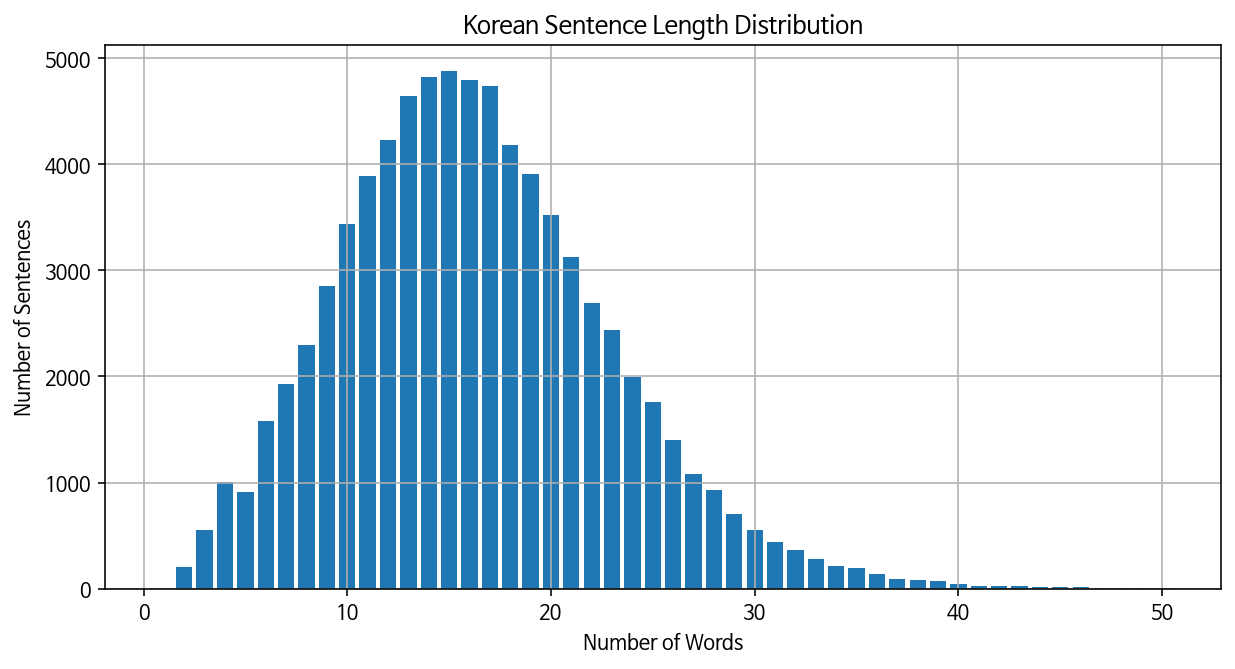

[English] 문장의 최단 길이: 2
[English] 문장의 최장 길이: 50
[English] 문장의 평균 길이: 24


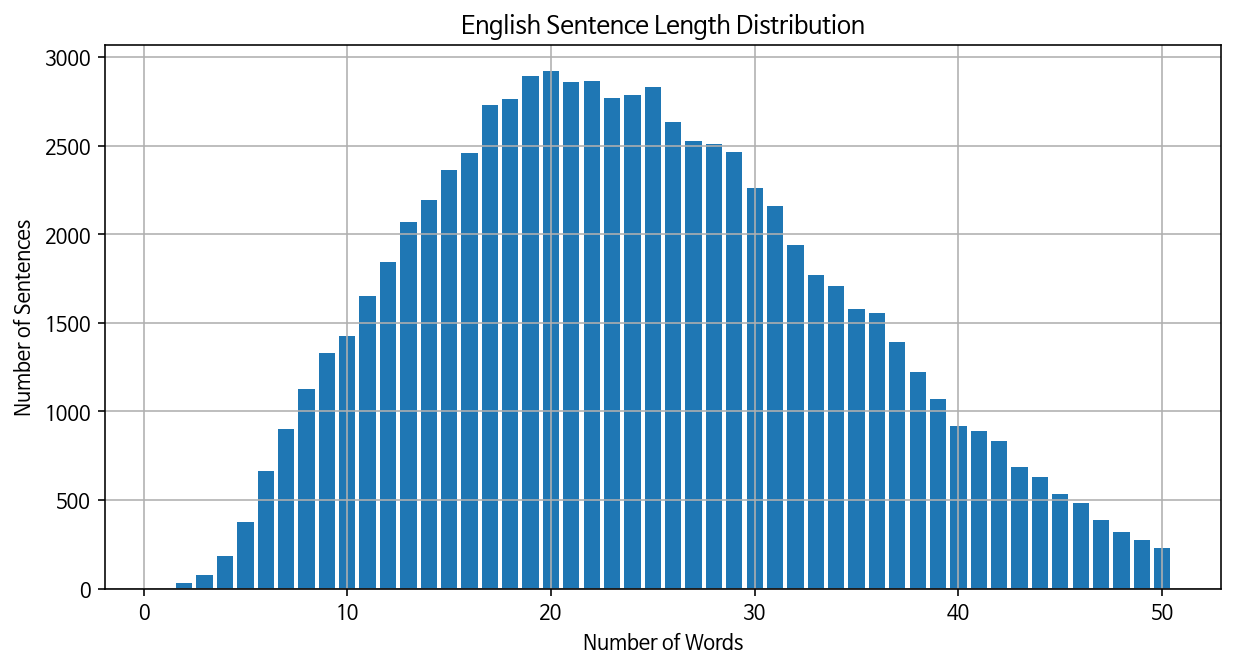

In [25]:
# 문장 리스트 분리
korean_sentences = [pair[0] for pair in cleaned_corpus]
english_sentences = [pair[1] for pair in cleaned_corpus]

# 시각화 및 통계 출력
korean_lengths = check_sentence_length(korean_sentences, "Korean")
english_lengths = check_sentence_length(english_sentences, "English")

- Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.

In [26]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer


In [27]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k = pair[0]
    e = pair[1]

    kor_corpus.append(k)
    eng_corpus.append(e)

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos") # 문장 양 끝에 <s> , </s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././ko_corpus.txt --model_prefix=ko_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>


True

177) LOG(INFO) Running command: --input=././en_corpus.txt --model_prefix=en_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././en_corpus.txt
  input_format: 
  model_prefix: en_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_pi

In [28]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    k_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])  
    e_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])
    
    src_corpus.append(k_tokens)
    tgt_corpus.append(e_tokens)
    
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, maxlen=MAX_LEN, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, maxlen=MAX_LEN, padding='post')

  0%|          | 0/77082 [00:00<?, ?it/s]

## Test Data

Total number of sentence pairs: 1945
Korean: 교황 존 폴 세의 교황청은 이 사건을 기적이라고 선언하였으며 , 테레사 수녀를 성자로 선언하는 데 방해가 되고 있던 마지막 장애물 중의 하나를 처리하게 되었다고 이탈리아 통신사들이 보도했다 .
English: pope john paul ii s office has declared the event a miracle , clearing one of the final hurdles standing in the way of declaring the nun a saint , italian news agencies reported .
[Korean] 문장의 최단 길이: 2
[Korean] 문장의 최장 길이: 43
[Korean] 문장의 평균 길이: 17


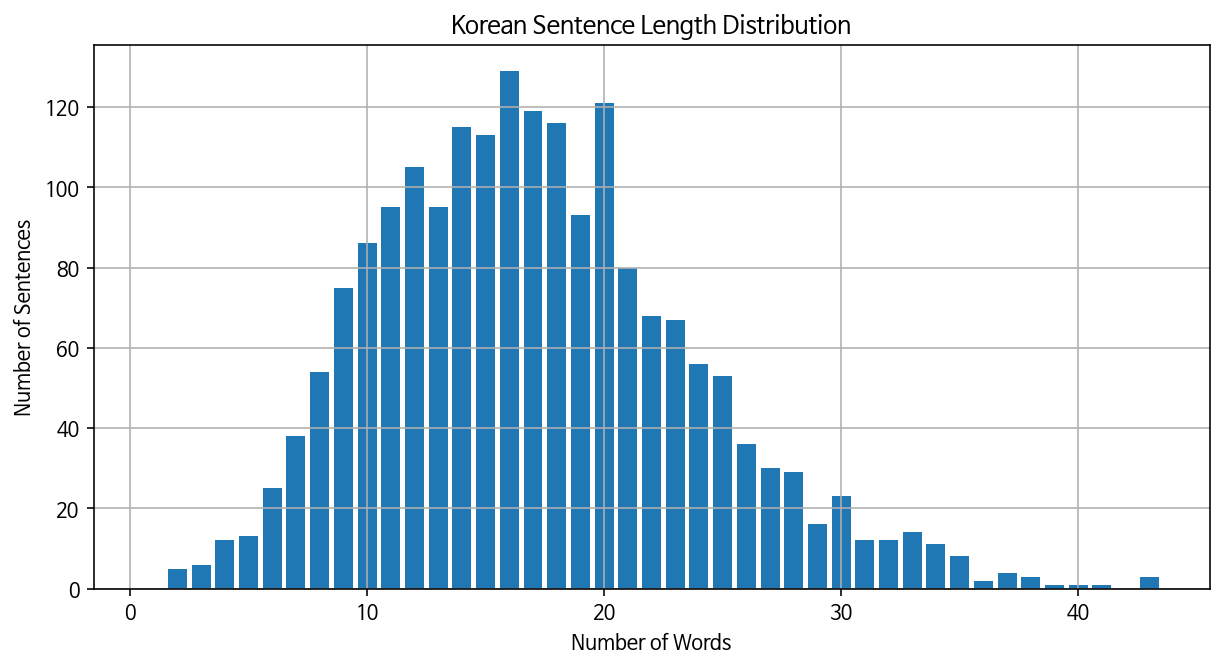

[English] 문장의 최단 길이: 2
[English] 문장의 최장 길이: 50
[English] 문장의 평균 길이: 24


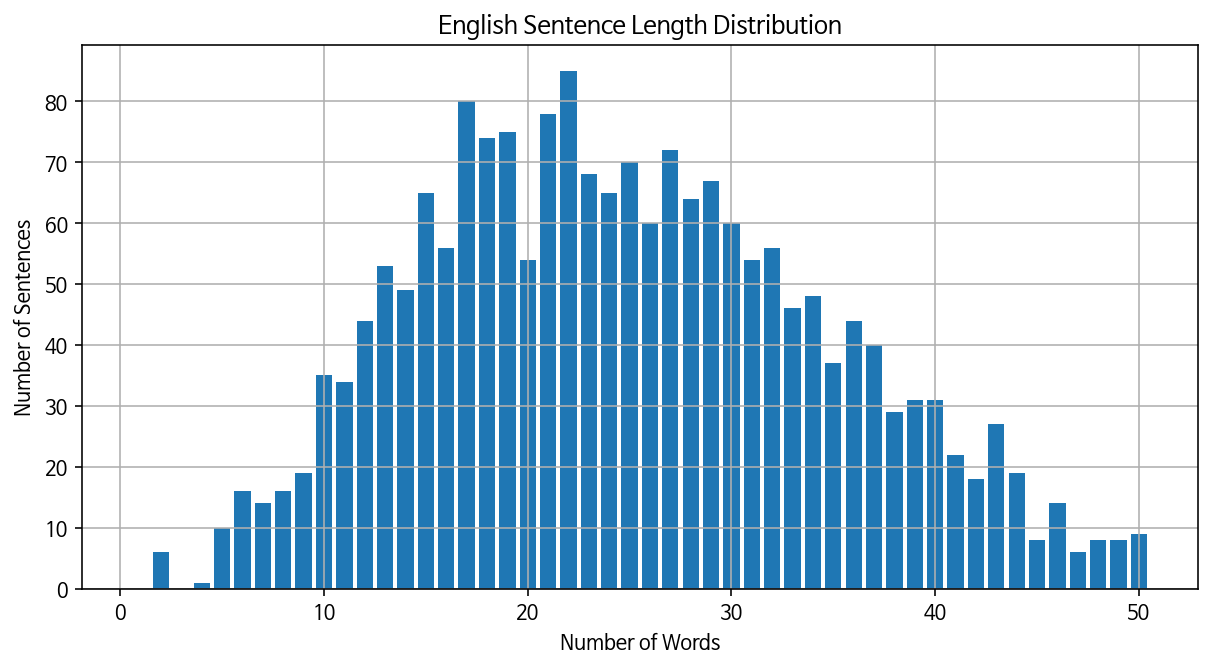

In [29]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/dat'
kor_test_path = data_dir+"/korean-english-park.test.ko"
eng_test_path = data_dir+"/korean-english-park.test.en"

cleaned_test_corpus = clean_corpus(kor_test_path, eng_test_path)

print(f"Total number of sentence pairs: {len(cleaned_test_corpus)}")
kor, eng= cleaned_test_corpus[10]
print("Korean:", kor)
print("English:", eng)

# 문장 리스트 분리
korean_sentences = [pair[0] for pair in cleaned_test_corpus]
english_sentences = [pair[1] for pair in cleaned_test_corpus]

# 시각화 및 통계 출력
korean_lengths = check_sentence_length(korean_sentences, "Korean")
english_lengths = check_sentence_length(english_sentences, "English")

 

In [30]:
# kor, eng 분리
kor_test_corpus = []
eng_test_corpus = []

for pair in cleaned_test_corpus:
    k = pair[0]
    e = pair[1]

    kor_test_corpus.append(k)
    eng_test_corpus.append(e)

print(f"Total number of sentence : {len(kor_test_corpus)}")
print("Korean:", kor_test_corpus[10])
print("English:", eng_test_corpus[10])

Total number of sentence : 1945
Korean: 교황 존 폴 세의 교황청은 이 사건을 기적이라고 선언하였으며 , 테레사 수녀를 성자로 선언하는 데 방해가 되고 있던 마지막 장애물 중의 하나를 처리하게 되었다고 이탈리아 통신사들이 보도했다 .
English: pope john paul ii s office has declared the event a miracle , clearing one of the final hurdles standing in the way of declaring the nun a saint , italian news agencies reported .


## 데이타 증강  --- Lexical Substitution

In [31]:
from gensim.models import KeyedVectors
ko_wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
print(ko_wv.most_similar("사랑"))

import gensim.downloader as api
en_wv = api.load('glove-wiki-gigaword-300')

[('슬픔', 0.7216663360595703), ('행복', 0.6759076714515686), ('절망', 0.6468985676765442), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937871932983), ('인생', 0.6216273903846741), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


In [36]:
from konlpy.tag import Okt
okt = Okt()
import random

def lexical_sub_korean(sentence, wv, tokenizer=okt, topn=1):
    tokens = tokenizer.morphs(sentence)
    candidates = [tok for tok in tokens if tok in wv]
    # Word2Vec에 없는 단어만 있는 경우 예외 처리
    if not candidates:
        return sentence
   
    # 대체할 단어 선택
    selected = random.choice(candidates)

    try:
        substitutes = wv.most_similar(selected, topn=topn)
        substitute = substitutes[0][0]
    except:
        substitute = selected

    new_tokens = [substitute if tok == selected else tok for tok in tokens]
    
    
    return ' '.join(new_tokens)
    
sentence = "그는 축구를 정말 잘한다."
print(lexical_sub_korean(sentence, ko_wv))

그 는 축구 을 정말 잘 한다 .


In [37]:
import re
import random

def lexical_sub(sentence, wv):
    # 알파벳만 남기고 정제
    sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)
    sample_tokens = sentence.split()

    # Word2Vec에 없는 단어만 있는 경우 예외 처리
    candidates = [tok for tok in sample_tokens if tok in wv]
    if not candidates:
        return None

    # 대체할 단어 선택
    selected_tok = random.choice(candidates)

    result = ""
    for tok in sample_tokens:
        if tok == selected_tok:
            try:
                result += wv.most_similar(tok)[0][0] + " "
            except KeyError:
                result += tok + " "
        else:
            result += tok + " "

    return result.strip()

In [61]:
# 원문+원문
# 증강+원문
# 원문+증강
kor_aug_corpus = []
eng_aug_corpus = []

for pair in cleaned_corpus:
    k = pair[0]
    e = pair[1]
    
    # 원문 추가
    kor_aug_corpus.append(k)
    eng_aug_corpus.append(e)
    
    # 한국어 증강 + 원문
    kor_new = lexical_sub_korean(k, ko_wv)
    if kor_new is not None:
        kor_aug_corpus.append(kor_new)
    else :
        kor_aug_corpus.append(k)
    eng_aug_corpus.append(e)
    
    # 원문 + 영어 증강
    kor_aug_corpus.append(k)
    eng_new = lexical_sub(e, en_wv)
    if eng_new is not None:
        eng_aug_corpus.append(eng_new)
    else :    
        eng_aug_corpus.append(e)

        
print(f"Total number of sentence : {len(kor_aug_corpus)}")
print("Korean:", kor_aug_corpus[1])
print("English:", eng_aug_corpus[1])
        

Total number of sentence : 231246
Korean: 배 목사 의 유해 는 그 의 유언 에 따라 경기도 안양시 의 병원 에 기증 되어 의학 연구 에 이용 될 것 이라고 , 그 의 형 이 언급 했다 .
English: bae s remains were to be donated to a hospital in anyang , gyeonggi province , for medical study in accordance with his will , his brother said .


In [62]:
ko_aug_tokenizer = generate_tokenizer(kor_aug_corpus, SRC_VOCAB_SIZE, "ko_aug")
en_aug_tokenizer = generate_tokenizer(eng_aug_corpus, TGT_VOCAB_SIZE, "en_aug")
en_aug_tokenizer.set_encode_extra_options("bos:eos") # 문장 양 끝에 <s> , </s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././ko_aug_corpus.txt --model_prefix=ko_aug_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././ko_aug_corpus.txt
  input_format: 
  model_prefix: ko_aug_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1
  u

True

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././en_aug_corpus.txt
  input_format: 
  model_prefix: en_aug_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 

In [63]:
print("Korean:", kor_aug_corpus[0])
print("English:", eng_aug_corpus[0])
print("Korean:", kor_aug_corpus[1])
print("English:", eng_aug_corpus[1])
print("Korean:", kor_aug_corpus[2])
print("English:", eng_aug_corpus[2])

Korean: 배 목사의 유해는 그의 유언에따라 경기도 안양시의 병원에 기증되어 의학 연구에 사용될 것이라고 , 그의 형이 언급했다 .
English: bae s remains were to be donated to a hospital in anyang , gyeonggi province , for medical study in accordance with his will , his brother said .
Korean: 배 목사 의 유해 는 그 의 유언 에 따라 경기도 안양시 의 병원 에 기증 되어 의학 연구 에 이용 될 것 이라고 , 그 의 형 이 언급 했다 .
English: bae s remains were to be donated to a hospital in anyang , gyeonggi province , for medical study in accordance with his will , his brother said .
Korean: 배 목사의 유해는 그의 유언에따라 경기도 안양시의 병원에 기증되어 의학 연구에 사용될 것이라고 , 그의 형이 언급했다 .
English: bae s remains were to be donated to a hospital in anyang gyeonggi province for hospital study in accordance with his will his brother said


In [64]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_aug_corpus = []
tgt_aug_corpus = []

assert len(kor_aug_corpus) == len(eng_aug_corpus)

for idx in tqdm(range(len(kor_aug_corpus))):
    k_tokens = ko_aug_tokenizer.encode_as_ids(kor_aug_corpus[idx])  
    e_tokens = en_aug_tokenizer.encode_as_ids(eng_aug_corpus[idx])
    
    src_aug_corpus.append(k_tokens)
    tgt_aug_corpus.append(e_tokens)
      
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_aug_train = tf.keras.preprocessing.sequence.pad_sequences(src_aug_corpus, maxlen=MAX_LEN, padding='post')
dec_aug_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_aug_corpus, maxlen=MAX_LEN, padding='post')

  0%|          | 0/231246 [00:00<?, ?it/s]

In [66]:
enc_aug_data = enc_aug_train[:80000]
dec_aug_data = dec_aug_train[:80000]
len(enc_aug_data)

80000

## 공통 함수

In [38]:
test_sentence = [
                '오바마는 대통령이다.', 
                '시민들은 도시 속에 산다.', 
                '커피는 필요 없다.',
                '일곱 명의 사망자가 발생했다.'
]

In [39]:
def test_evaluate(model, test_sentences, src_tokenizer, tgt_tokenizer ):
    for(idx, sentence) in enumerate(test_sentences): 
        pieces, result, enc_attns, dec_attns, dec_enc_attns = \
            evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
        
        print(f"{idx}. {sentence}")
        print(f">>  {result}")

In [40]:
def test_translate(model, test_sentences, src_tokenizer, tgt_tokenizer):
    for(idx, sentence) in enumerate(test_sentences): 
        translate(sentence, model, src_tokenizer, tgt_tokenizer, True)


In [41]:
import matplotlib.pyplot as plt
def display_loss_graph( ephoch_losses ): 
    # 에폭과 손실 리스트 분리
    epochs = [entry['epochs'] for entry in ephoch_losses]
    losses = [entry['loss'] for entry in ephoch_losses]


    # 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker='o', color='blue', label='Train Loss')
    plt.title('Train Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
# train 동작

def train_transfomer(config, transformer, enc_train, dec_train, src_tokenizer, tgt_tokenizer, max_epochs, train_losses ) :
    
    print("Test Set Count (No augment) : ", len(enc_train))
    print("")
    print("Hyperparameters")
    print(f"> n_layers : {config.n_layers}")
    print(f"> d_model : {config.d_model}")
    print(f"> n_heads : {config.n_heads}")
    print(f"> d_ff : {config.d_ff}")
    print(f"> dropout : {config.dropout_rate}")
    
    print("")
    print("Training Parameters")
    print(f"> Warmup Steps : {WARMUP_STEPS}")
    print(f"> Batch Size : {config.batch_size}")
    print(f"> Epoch : {max_epochs}")
    batch_size = config.batch_size


    train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=batch_size)

    for epoch in range(max_epochs):
        total_loss = 0
        test_batches = 0
    
        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        # tqdm 안에 iterable을 넣는다
        tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count)
    
        for batch, (enc_batch, dec_batch) in tqdm_bar: 
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                train_step( enc_batch, 
                                dec_batch, 
                                transformer, 
                                optimizer
                                )
        
            total_loss += batch_loss  
            test_batches += 1

        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (test_batches  + 1)))    # tqdm
    
        train_losses.append ( {
            'epochs' : epoch+1,
             'loss' : total_loss.numpy()/test_batches 
            })
    
        print(f"Epoch: {epoch+1}  loss={total_loss / test_batches:.4f}")
   
        print("")
        print("Translations Epoch At :", {epoch+1})
        test_evaluate(transformer, test_sentence, src_tokenizer, tgt_tokenizer)
    
    return train_losses
    


# Test Cas 1.  증강없음, 2 Layer

In [48]:
# 2 Layer

from dataclasses import dataclass

class TransformerCase1Config:
    n_layers: int = 2
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    dropout_rate: float = 0.3
    batch_size: int = 64

config = TransformerCase1Config()


transformer_2layer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=config.dropout_rate,
    shared_fc=True)

EPOCHS = 10

model_1_loss = []
model_1_loss = train_transfomer(config, transformer_2layer, enc_train, dec_train, \
                                ko_tokenizer, en_tokenizer, EPOCHS, model_1_loss)

Test Set Count (No augment) :  77082

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch : 10


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 1  loss=4.7574

Translations Epoch At : {1}
0. 오바마는 대통령이다.
>>  president , .
1. 시민들은 도시 속에 산다.
>>  since .
2. 커피는 필요 없다.
>>  and is .
3. 일곱 명의 사망자가 발생했다.
>>  police said .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 2  loss=1.4336

Translations Epoch At : {2}
0. 오바마는 대통령이다.
>>  susan s .
1. 시민들은 도시 속에 산다.
>>  susan , police said .
2. 커피는 필요 없다.
>>  susan known as .
3. 일곱 명의 사망자가 발생했다.
>>  correspondent , police said .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 3  loss=0.9279

Translations Epoch At : {3}
0. 오바마는 대통령이다.
>>  state s national campaign . s nomination .
1. 시민들은 도시 속에 산다.
>>  south , ancient u .
2. 커피는 필요 없다.
>>  .
3. 일곱 명의 사망자가 발생했다.
>>  . , and other people deadly deadly dead dead dead dead dead dead of dead of homes .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 4  loss=0.6839

Translations Epoch At : {4}
0. 오바마는 대통령이다.
>>  democratic campaign democratic campaign campaign mccain .
1. 시민들은 도시 속에 산다.
>>  shiites of baghdad in baghdad .
2. 커피는 필요 없다.
>>  explains , we are goings .
3. 일곱 명의 사망자가 발생했다.
>>  meng , another hospital .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 5  loss=0.4748

Translations Epoch At : {5}
0. 오바마는 대통령이다.
>>  traitor go democratic campaign .
1. 시민들은 도시 속에 산다.
>>  explains south pole area .
2. 커피는 필요 없다.
>>  rakas they reuters .
3. 일곱 명의 사망자가 발생했다.
>>  uters . police checkpoint men


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 6  loss=0.2838

Translations Epoch At : {6}
0. 오바마는 대통령이다.
>>  shiite red mosque . .
1. 시민들은 도시 속에 산다.
>>  granger her tuesday morning . reported missing collapsed .
2. 커피는 필요 없다.
>>  .
3. 일곱 명의 사망자가 발생했다.
>>  actor they others died died children died .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 7  loss=0.1523

Translations Epoch At : {7}
0. 오바마는 대통령이다.
>>  ap , an earlier .
1. 시민들은 도시 속에 산다.
>>  police , police said monday .
2. 커피는 필요 없다.
>>  have experiencer added that names about that process contain american american american troops experience american american workers suggest that friday friday friday friday friday friday contain american american american american american american american troops friday friday friday contain process .
3. 일곱 명의 사망자가 발생했다.
>>  others , police checkpoint incident


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 8  loss=0.0961

Translations Epoch At : {8}
0. 오바마는 대통령이다.
>>  up to democrat in november election campaign .
1. 시민들은 도시 속에 산다.
>>  uters reported .
2. 커피는 필요 없다.
>>  uters you re doing you want direct american american re going to want to you re doing what you re doing you re doing sex problems .
3. 일곱 명의 사망자가 발생했다.
>>  others , police .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 9  loss=0.0711

Translations Epoch At : {9}
0. 오바마는 대통령이다.
>>  half to checkpoint .
1. 시민들은 도시 속에 산다.
>>  police officers , officials said .
2. 커피는 필요 없다.
>>  now we mustn all what re re not identified re not want to re not re not re not re not re not yet re not identified
3. 일곱 명의 사망자가 발생했다.
>>  wounded in killed wounded wounded six death .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 10  loss=0.0559

Translations Epoch At : {10}
0. 오바마는 대통령이다.
>>  republican to her iowa campaign .
1. 시민들은 도시 속에 산다.
>>  police said .
2. 커피는 필요 없다.
>>  cup we don you not want her courage her courage her courage that she want that want her that want her courage her courage what she board she want what she want that want her cat her courage her courage her courage her courage her courage her courage her
3. 일곱 명의 사망자가 발생했다.
>>  authorit kill five month homes


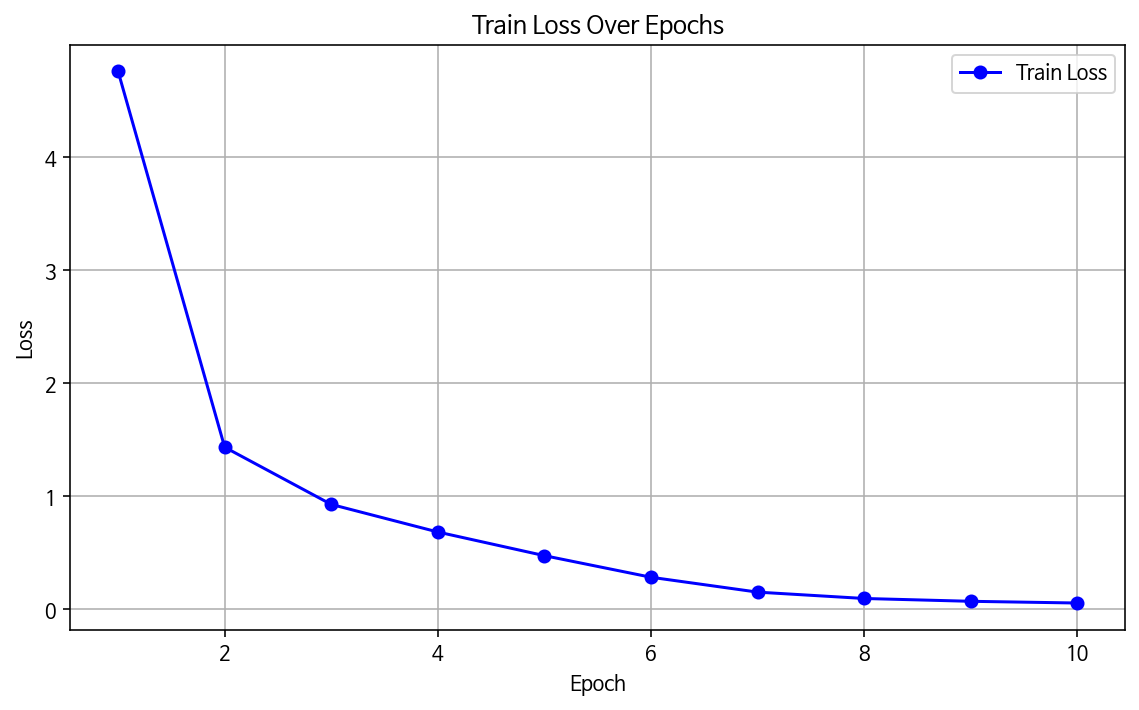

In [49]:
display_loss_graph(model_1_loss)

Translations and Attention Map
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: authorit kill five month homes
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


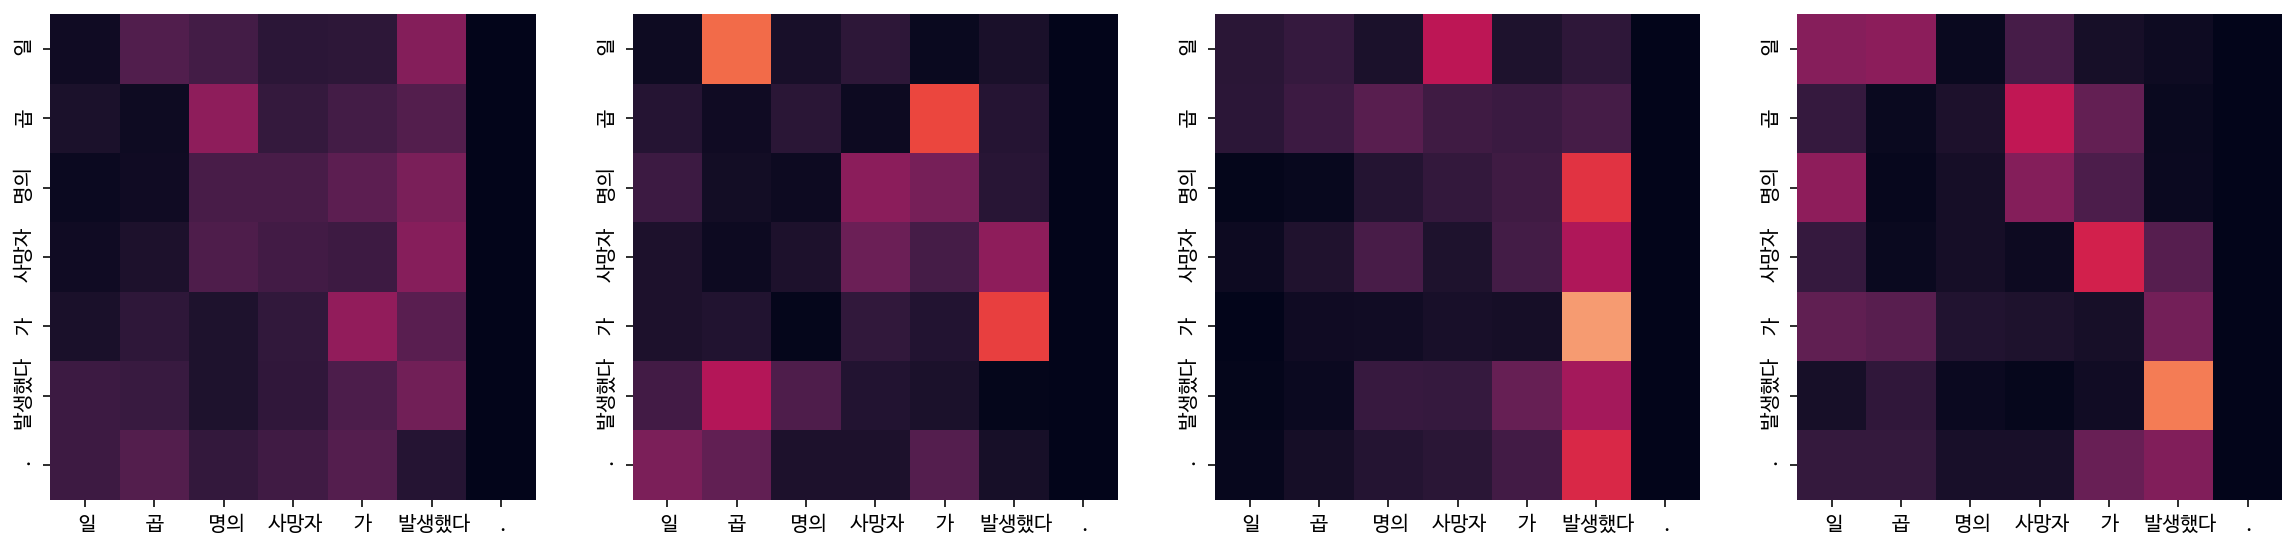

Encoder Layer 2


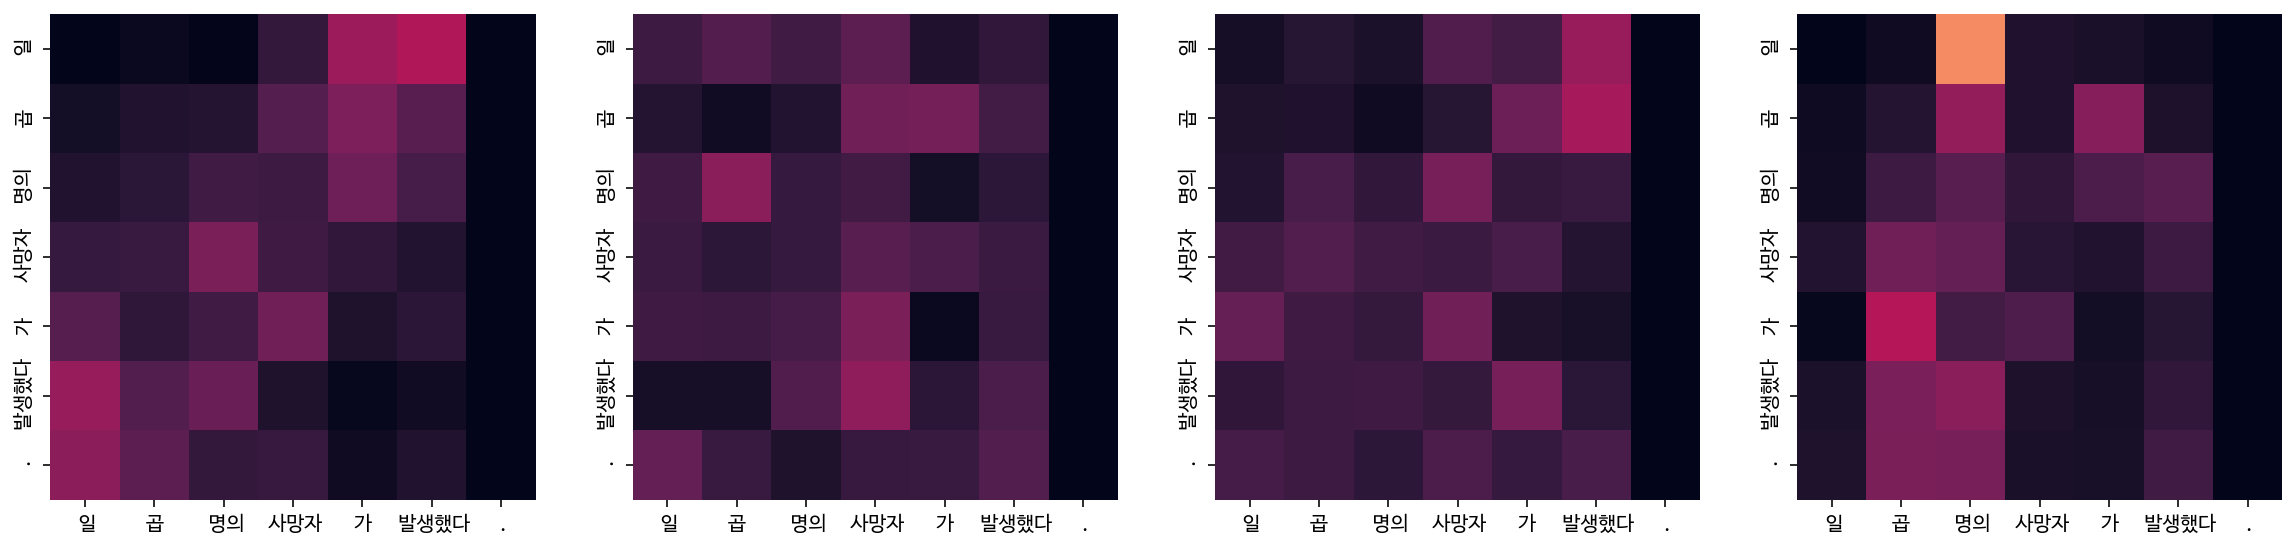

Decoder Self Layer 1


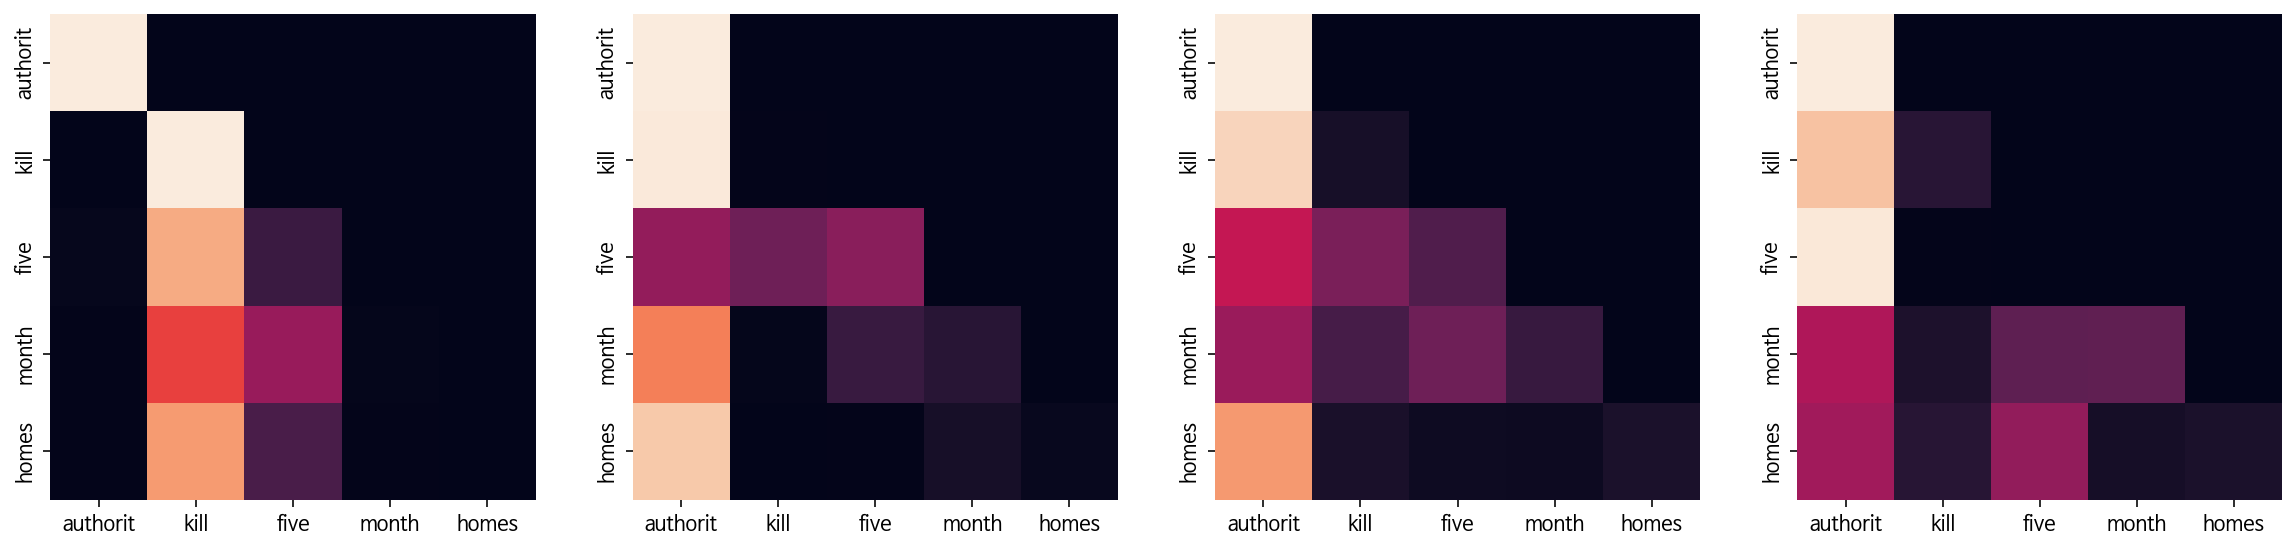

Decoder Src Layer 1


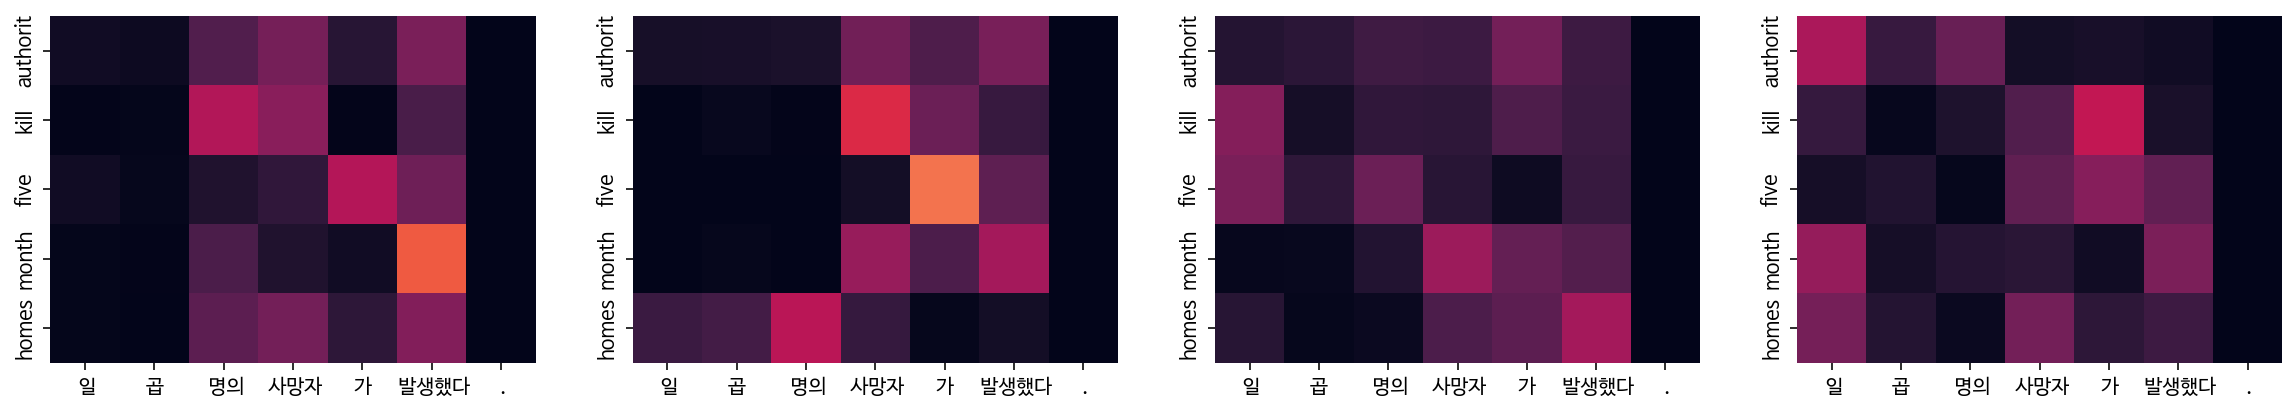

Decoder Self Layer 2


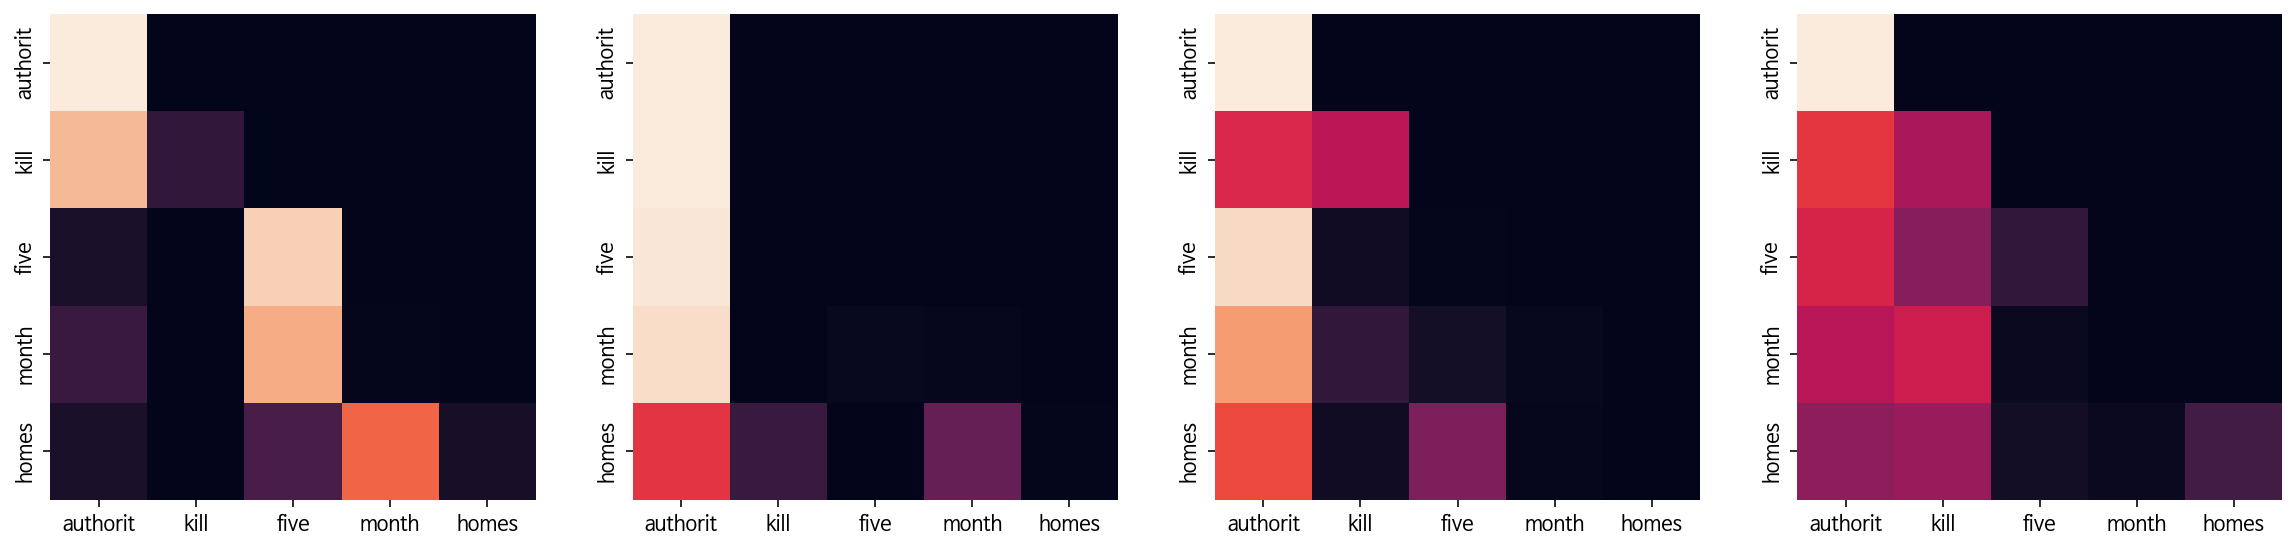

Decoder Src Layer 2


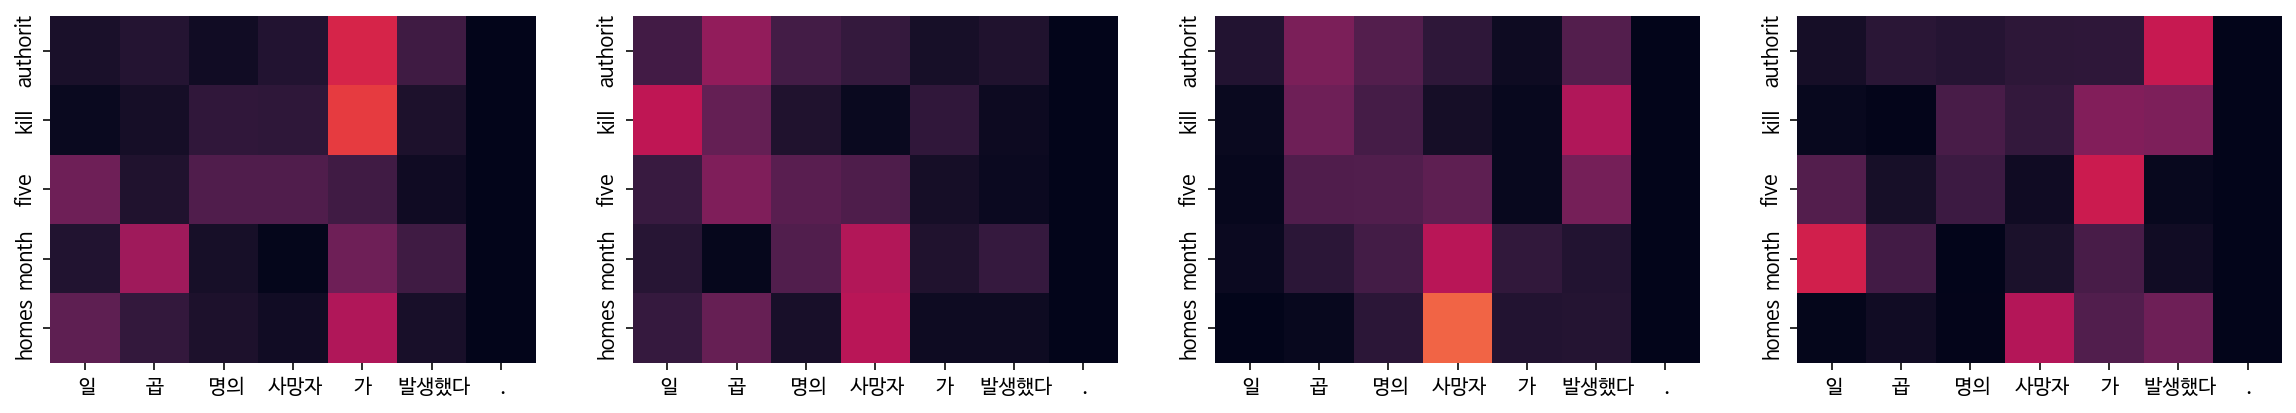

In [51]:
print("Translations and Attention Map")
sentence = [
    '일곱 명의 사망자가 발생했다.'
]
test_translate(transformer_2layer, sentence, ko_tokenizer, en_tokenizer)



In [52]:
# Bleu Score 
eval_bleu(transformer_2layer, kor_test_corpus, eng_test_corpus, ko_tokenizer, en_tokenizer, MAX_LEN, False)


<class 'str'>


  0%|          | 0/1945 [00:00<?, ?it/s]

Num of Sample: 1945
Total Score: 0.0037676749369942013


# Test Cas 2.  증강없음, 6 Layer

In [53]:
# 6 Layer
class TransformerCase2Config:
    n_layers: int = 6
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    dropout_rate: float = 0.3
    batch_size: int = 64

config = TransformerCase2Config()


transformer_6layer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=config.dropout_rate,
    shared_fc=True)


EPOCHS = 10

model_2_loss = []
model_2_loss = train_transfomer(config, transformer_6layer, enc_train, dec_train, \
                                ko_tokenizer, en_tokenizer, EPOCHS, model_2_loss)

Test Set Count (No augment) :  77082

Hyperparameters
> n_layers : 6
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch : 10


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 1  loss=2.3246

Translations Epoch At : {1}
0. 오바마는 대통령이다.
>>  mccain .
1. 시민들은 도시 속에 산다.
>>  thomas said .
2. 커피는 필요 없다.
>>  tris .
3. 일곱 명의 사망자가 발생했다.
>>  cambridge statement said monday .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 2  loss=0.7096

Translations Epoch At : {2}
0. 오바마는 대통령이다.
>>  delegates .
1. 시민들은 도시 속에 산다.
>>  doctors system .
2. 커피는 필요 없다.
>>  pent .
3. 일곱 명의 사망자가 발생했다.
>>  suspicious police said .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 3  loss=0.2279

Translations Epoch At : {3}
0. 오바마는 대통령이다.
>>  winger vote election .
1. 시민들은 도시 속에 산다.
>>  , heathrow pool
2. 커피는 필요 없다.
>>  , heers .
3. 일곱 명의 사망자가 발생했다.
>>  ethiopian vessel june .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 4  loss=0.1228

Translations Epoch At : {4}
0. 오바마는 대통령이다.
>>  democratic party party appointment party care speech .
1. 시민들은 도시 속에 산다.
>>  syria .
2. 커피는 필요 없다.
>>  eda martial jet it
3. 일곱 명의 사망자가 발생했다.
>>  saturday .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 5  loss=0.0806

Translations Epoch At : {5}
0. 오바마는 대통령이다.
>>  that vote
1. 시민들은 도시 속에 산다.
>>  tehran reports .
2. 커피는 필요 없다.
>>  gates officials officials
3. 일곱 명의 사망자가 발생했다.
>>  reported reported .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 6  loss=0.0619

Translations Epoch At : {6}
0. 오바마는 대통령이다.
>>  some .
1. 시민들은 도시 속에 산다.
>>  pennsylvania .
2. 커피는 필요 없다.
>>  they toxic marketss managements towns , markets , societyss society .
3. 일곱 명의 사망자가 발생했다.
>>  newspaper announc .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 7  loss=0.0544

Translations Epoch At : {7}
0. 오바마는 대통령이다.
>>  contests . contests presidential election sen .
1. 시민들은 도시 속에 산다.
>>  abbasy .
2. 커피는 필요 없다.
>>  ethnic debris .
3. 일곱 명의 사망자가 발생했다.
>>  


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 8  loss=0.0513

Translations Epoch At : {8}
0. 오바마는 대통령이다.
>>  clinton held abbas . time time time time time time time iraq time time time iraq . iraq . time . party time time time party party party party party party party party  time time time . party . iraq . i service time party service time service party
1. 시민들은 도시 속에 산다.
>>  a embassy of of industrial of suicide suicide federal suicide ago , suicide suicide federal suicide suicide suicide federal federal suicide suicide suicide suicide suicide suicide charge of suicide charge of suicide charge of suicide suicide suicide .
2. 커피는 필요 없다.
>>  no years .
3. 일곱 명의 사망자가 발생했다.
>>  mine restrict .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 9  loss=0.0493

Translations Epoch At : {9}
0. 오바마는 대통령이다.
>>  american party .
1. 시민들은 도시 속에 산다.
>>  both sides westst others .
2. 커피는 필요 없다.
>>  even hiv andnnn internet and internet and shoping and education and internet and society and internet and internet and internet sites at suggesting society suggesting shops and internet .
3. 일곱 명의 사망자가 발생했다.
>>  american american cnn military military of mass destructioned in july of mass destruction .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 10  loss=0.0468

Translations Epoch At : {10}
0. 오바마는 대통령이다.
>>  her .
1. 시민들은 도시 속에 산다.
>>  .
2. 커피는 필요 없다.
>>  really to .
3. 일곱 명의 사망자가 발생했다.
>>  hamas states .


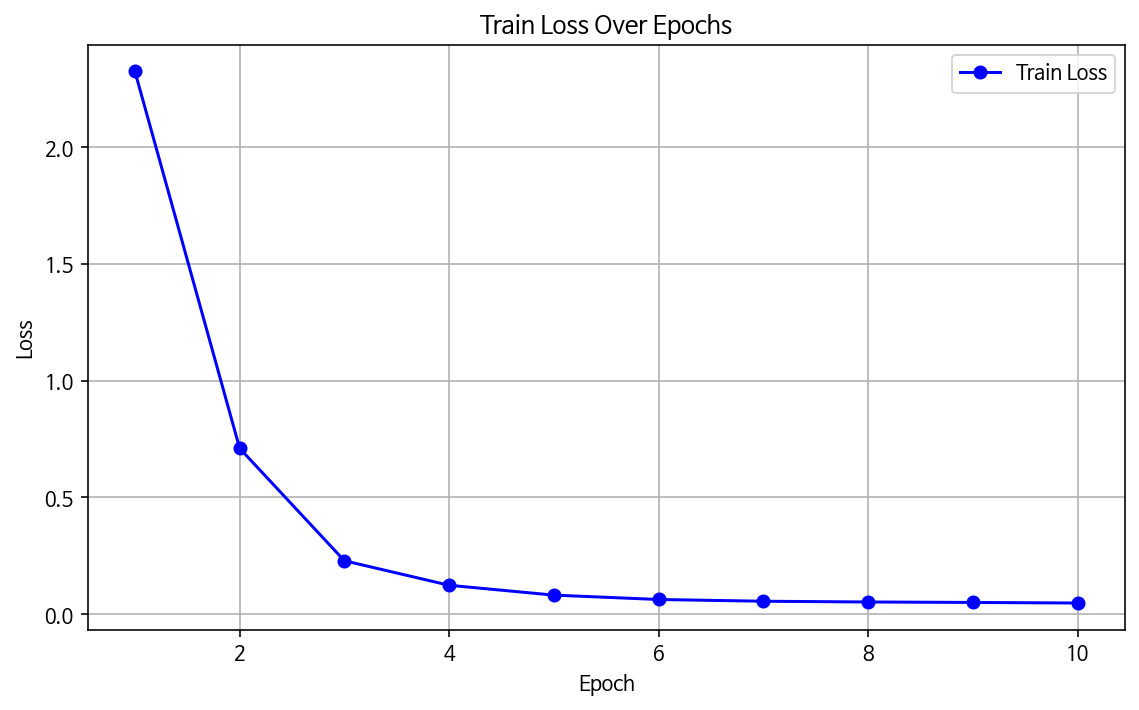

In [54]:
display_loss_graph(model_2_loss)

Translations and Attention Map
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: hamas states .
Encoder Layer 1


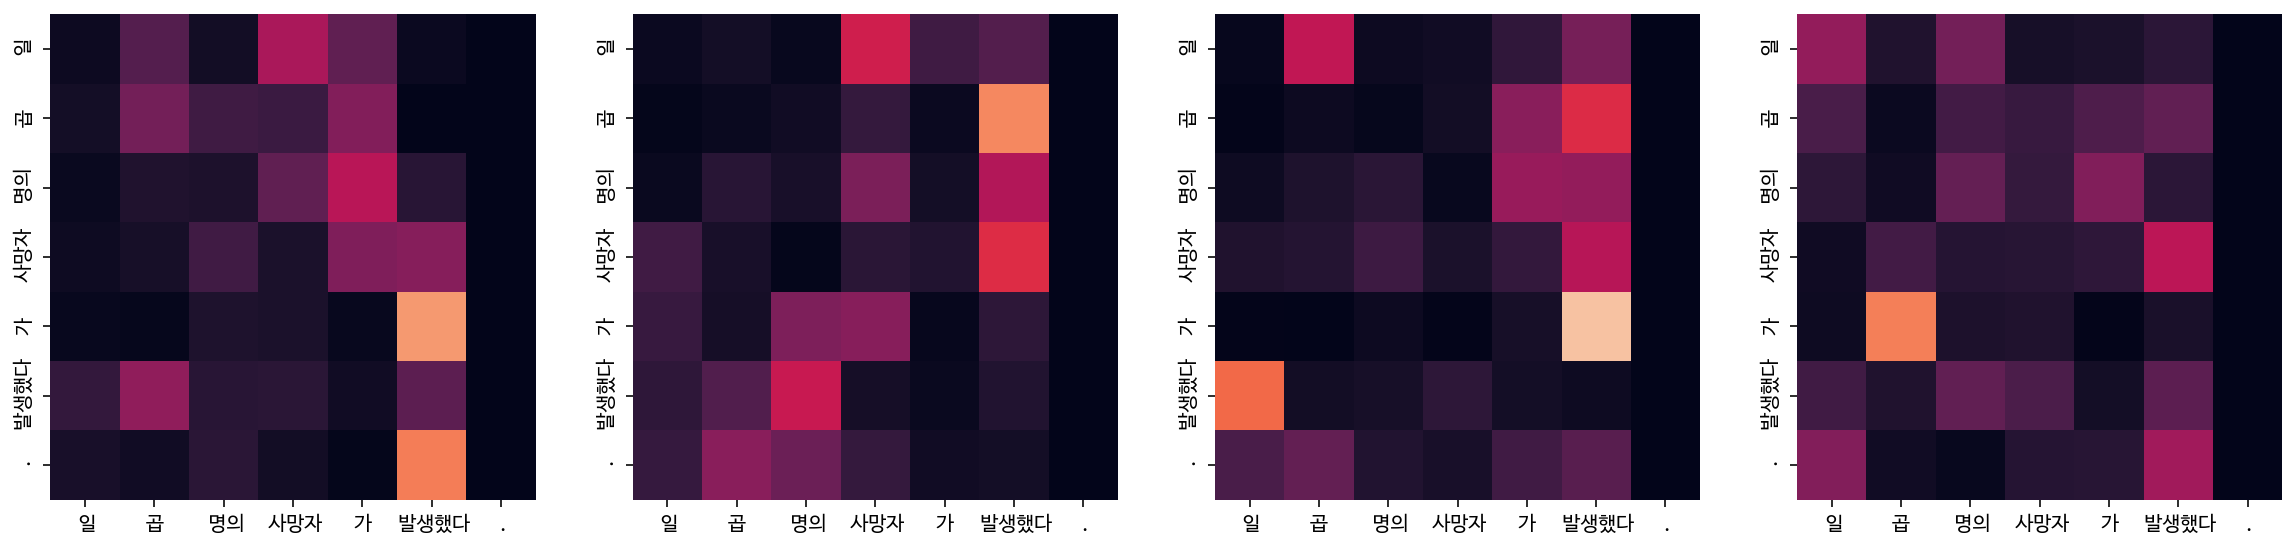

Encoder Layer 2


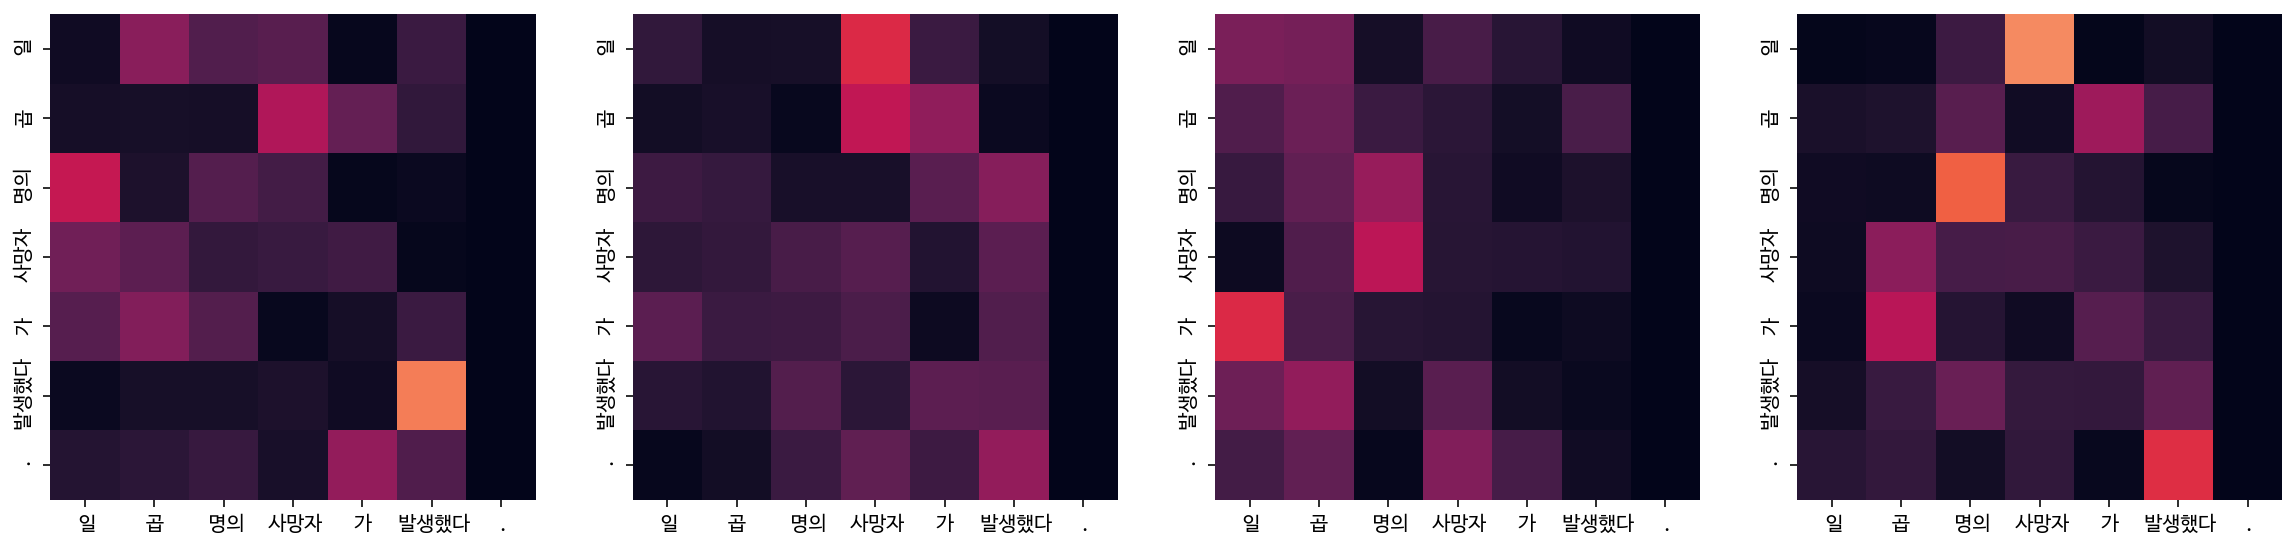

Decoder Self Layer 1


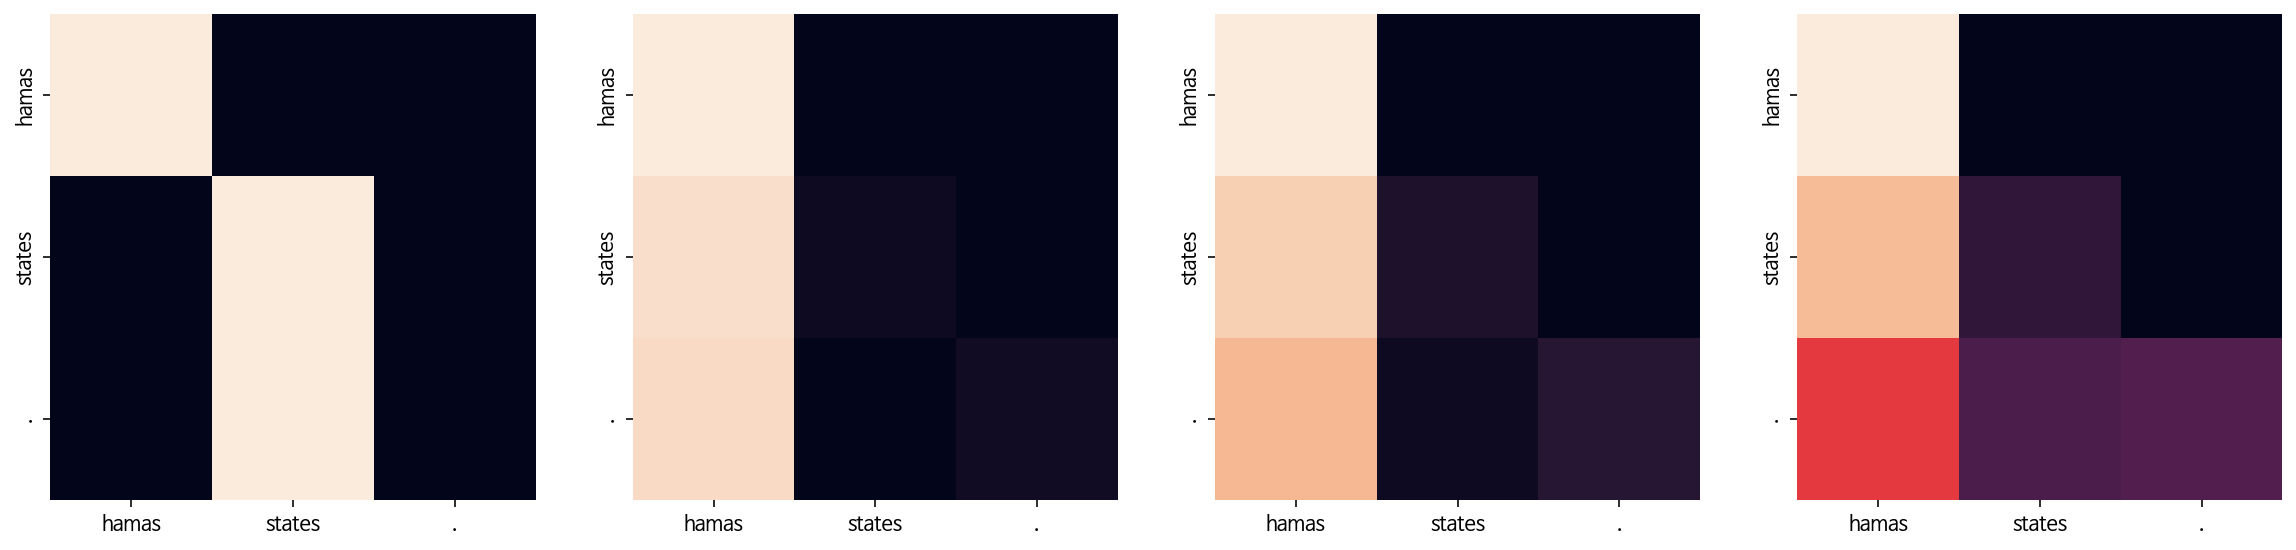

Decoder Src Layer 1


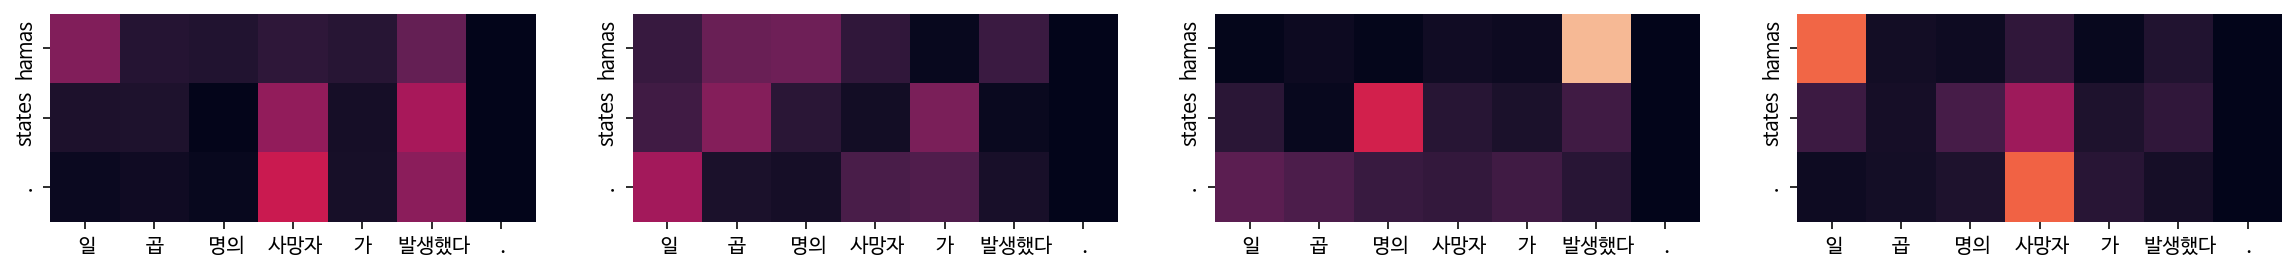

Decoder Self Layer 2


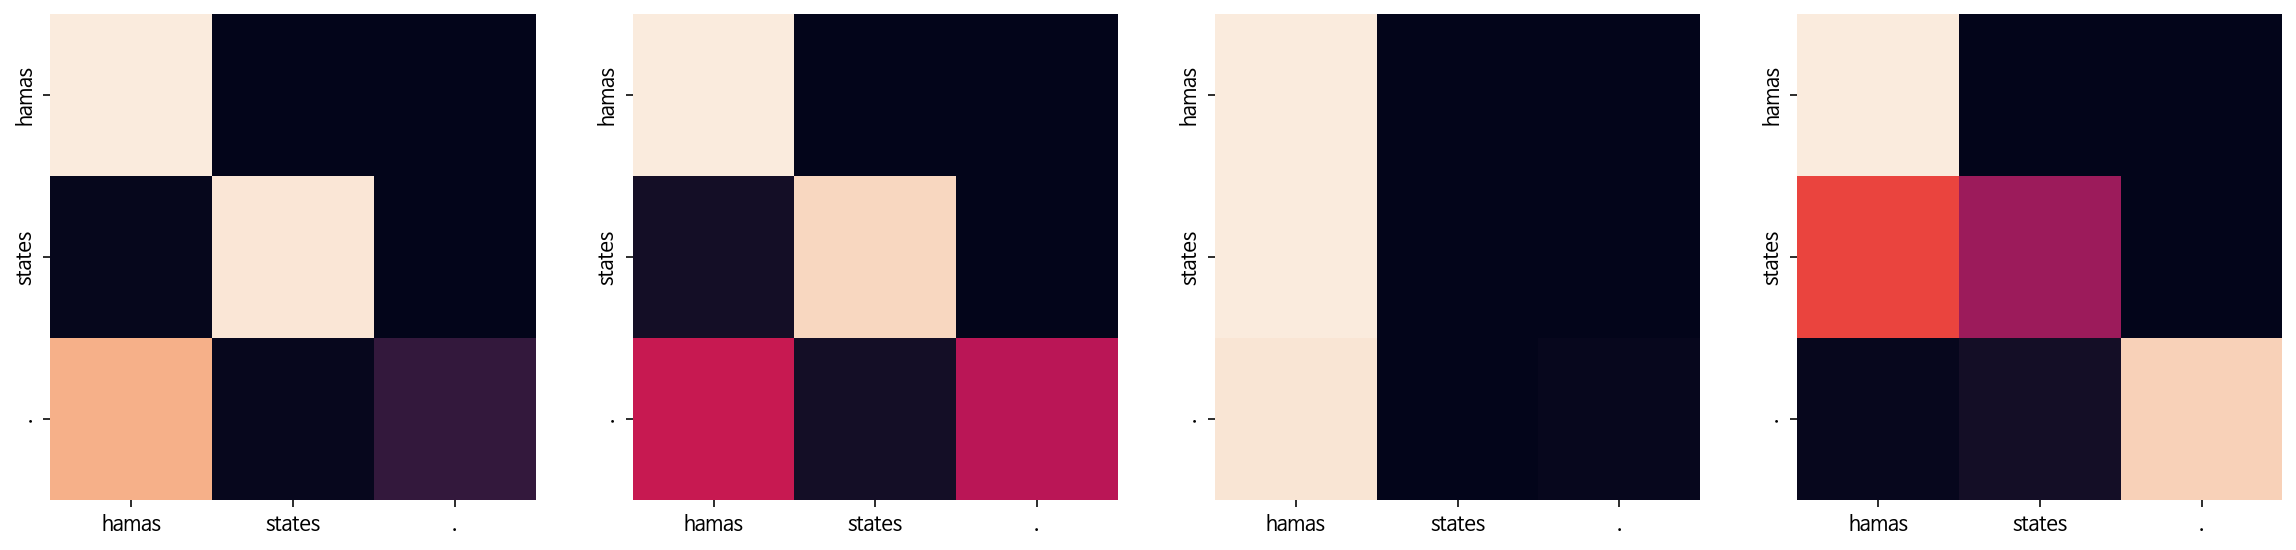

Decoder Src Layer 2


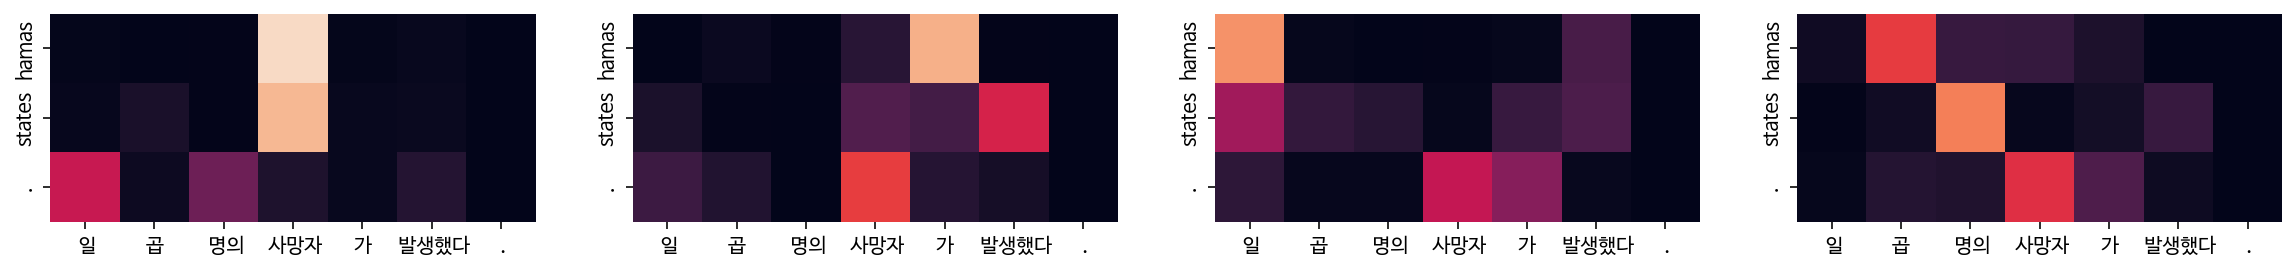

In [56]:
print("Translations and Attention Map")
sentence = [
    '일곱 명의 사망자가 발생했다.'
]
test_translate(transformer_6layer, sentence, ko_tokenizer, en_tokenizer)

In [57]:
# Bleu Score 
eval_bleu(transformer_6layer, kor_test_corpus, eng_test_corpus, ko_tokenizer, en_tokenizer, MAX_LEN, False)

<class 'str'>


  0%|          | 0/1945 [00:00<?, ?it/s]

Num of Sample: 1945
Total Score: 0.001688225805260258


# Test Cas 3. 증강없음, 4 Layer

In [58]:
# 4 Layer
class TransformerCase3Config:
    n_layers: int = 4
    d_model: int = 256
    n_heads: int = 8
    d_ff: int = 2048
    dropout_rate: float = 0.3
    batch_size: int = 64

config = TransformerCase3Config()


transformer_4layer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=config.dropout_rate,
    shared_fc=True)


EPOCHS = 10

model_3_loss = []
model_3_loss = train_transfomer(config, transformer_4layer, enc_train, dec_train, \
                                ko_tokenizer, en_tokenizer, EPOCHS, model_3_loss)

Test Set Count (No augment) :  77082

Hyperparameters
> n_layers : 4
> d_model : 256
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch : 10


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 1  loss=2.7736

Translations Epoch At : {1}
0. 오바마는 대통령이다.
>>  vice president very small year old nuclear programs .
1. 시민들은 도시 속에 산다.
>>  saying that many of her .
2. 커피는 필요 없다.
>>  singapore are are also have been a year old .
3. 일곱 명의 사망자가 발생했다.
>>  hawaii president don finding lot of baghdad .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 2  loss=1.3630

Translations Epoch At : {2}
0. 오바마는 대통령이다.
>>  rpol
1. 시민들은 도시 속에 산다.
>>  witnesses told sarkozy s .
2. 커피는 필요 없다.
>>  authority
3. 일곱 명의 사망자가 발생했다.
>>  pakistani officials .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 3  loss=0.9323

Translations Epoch At : {3}
0. 오바마는 대통령이다.
>>  sceptica
1. 시민들은 도시 속에 산다.
>>  benazir
2. 커피는 필요 없다.
>>  sceptic .
3. 일곱 명의 사망자가 발생했다.
>>  sceptic official said


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 4  loss=0.4817

Translations Epoch At : {4}
0. 오바마는 대통령이다.
>>  sen .
1. 시민들은 도시 속에 산다.
>>  authority .
2. 커피는 필요 없다.
>>  fester , it s been been
3. 일곱 명의 사망자가 발생했다.
>>  benazirel is set upcoming


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 5  loss=0.2885

Translations Epoch At : {5}
0. 오바마는 대통령이다.
>>  sen .
1. 시민들은 도시 속에 산다.
>>  benazir poohs .
2. 커피는 필요 없다.
>>  researchers watch .
3. 일곱 명의 사망자가 발생했다.
>>  authorities said .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 6  loss=0.1903

Translations Epoch At : {6}
0. 오바마는 대통령이다.
>>  announced .
1. 시민들은 도시 속에 산다.
>>  yang s . . . .
2. 커피는 필요 없다.
>>  office .
3. 일곱 명의 사망자가 발생했다.
>>  penn officials .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 7  loss=0.1299

Translations Epoch At : {7}
0. 오바마는 대통령이다.
>>  joe also s .
1. 시민들은 도시 속에 산다.
>>  found s . . s .
2. 커피는 필요 없다.
>>  ed some watch .
3. 일곱 명의 사망자가 발생했다.
>>  penn has run .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 8  loss=0.0896

Translations Epoch At : {8}
0. 오바마는 대통령이다.
>>  mary . . . . .
1. 시민들은 도시 속에 산다.
>>  found .
2. 커피는 필요 없다.
>>  est she know .
3. 일곱 명의 사망자가 발생했다.
>>  like watch a .


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 9  loss=0.0646

Translations Epoch At : {9}
0. 오바마는 대통령이다.
>>  including president .
1. 시민들은 도시 속에 산다.
>>  like s .
2. 커피는 필요 없다.
>>  ed that she such and
3. 일곱 명의 사망자가 발생했다.
>>  ed to watched to cnn


  0%|          | 0/1205 [00:00<?, ?it/s]

Epoch: 10  loss=0.0501

Translations Epoch At : {10}
0. 오바마는 대통령이다.
>>  wastesremlin race . . .
1. 시민들은 도시 속에 산다.
>>  like s . . . .
2. 커피는 필요 없다.
>>  ed she is more than finds needed drinks drinks getting finds right selling than finding way again this way again find how way again making great perils can find than than than than than than than than than
3. 일곱 명의 사망자가 발생했다.
>>  take he was an investigation s home .


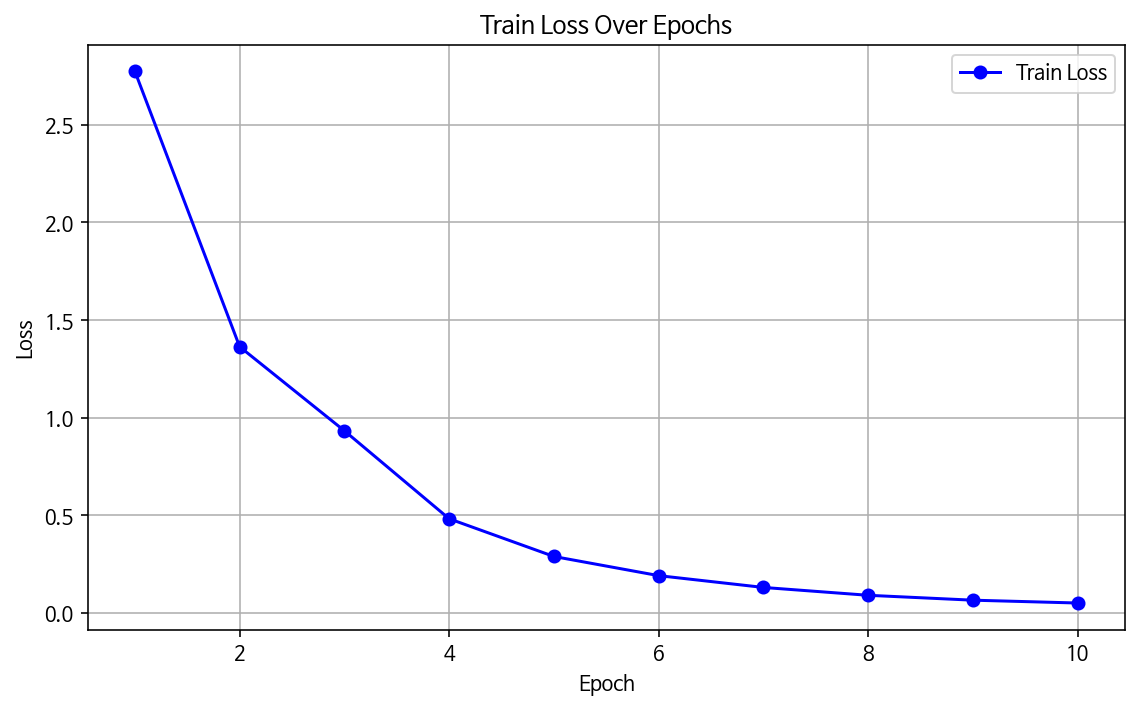

In [59]:
display_loss_graph(model_3_loss)

In [60]:
# Bleu Score 
eval_bleu(transformer_4layer, kor_test_corpus, eng_test_corpus, ko_tokenizer, en_tokenizer, MAX_LEN, False)

<class 'str'>


  0%|          | 0/1945 [00:00<?, ?it/s]

Num of Sample: 1945
Total Score: 0.003501385868121823


# Test Cas 4. 증강->80000, 2 Layer

In [67]:
config = TransformerCase1Config()


transformer_2layer_aug = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=config.dropout_rate,
    shared_fc=True)

EPOCHS = 10

model_4_loss = []
model_4_loss = train_transfomer(config, transformer_2layer_aug, enc_aug_data, dec_aug_data, \
                                ko_aug_tokenizer, en_aug_tokenizer, EPOCHS, model_4_loss)

Test Set Count (No augment) :  80000

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch : 10


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 1  loss=3.4133

Translations Epoch At : {1}
0. 오바마는 대통령이다.
>>  mccain
1. 시민들은 도시 속에 산다.
>>  rio .
2. 커피는 필요 없다.
>>  mugabe
3. 일곱 명의 사망자가 발생했다.
>>  mugabe .


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 2  loss=1.5858

Translations Epoch At : {2}
0. 오바마는 대통령이다.
>>  hotte said
1. 시민들은 도시 속에 산다.
>>  framedo
2. 커피는 필요 없다.
>>  hotte .
3. 일곱 명의 사망자가 발생했다.
>>  hotte


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 3  loss=1.2545

Translations Epoch At : {3}
0. 오바마는 대통령이다.
>>  mccain obama administration
1. 시민들은 도시 속에 산다.
>>  halleroached mcms
2. 커피는 필요 없다.
>>  iful season
3. 일곱 명의 사망자가 발생했다.
>>  stationcvirus


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 4  loss=0.9511

Translations Epoch At : {4}
0. 오바마는 대통령이다.
>>  barack obama administration
1. 시민들은 도시 속에 산다.
>>  boulder shack canterbury
2. 커피는 필요 없다.
>>  homicide .
3. 일곱 명의 사망자가 발생했다.
>>  rees ambassador prat halle


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 5  loss=0.6819

Translations Epoch At : {5}
0. 오바마는 대통령이다.
>>  mccain
1. 시민들은 도시 속에 산다.
>>  boulder alone shack aucklandsc
2. 커피는 필요 없다.
>>  gerr .
3. 일곱 명의 사망자가 발생했다.
>>  colombia according to halle a pup toward that region that elections in a elections and region monday .


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 6  loss=0.4734

Translations Epoch At : {6}
0. 오바마는 대통령이다.
>>  mccain
1. 시민들은 도시 속에 산다.
>>  mosle week afternoons said
2. 커피는 필요 없다.
>>  belarus .
3. 일곱 명의 사망자가 발생했다.
>>  wto interfax reported on monday


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 7  loss=0.3305

Translations Epoch At : {7}
0. 오바마는 대통령이다.
>>  chicago phone arrested back problems
1. 시민들은 도시 속에 산다.
>>  reconstruction district court mountain center
2. 커피는 필요 없다.
>>  guerrillas .
3. 일곱 명의 사망자가 발생했다.
>>  colombia triggered said monday one of of bda out carry out carry out in a monday


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 8  loss=0.2440

Translations Epoch At : {8}
0. 오바마는 대통령이다.
>>  arrested him hyun proposal problems hoping from talent williams from location of before williams williams hop back from police williams told reporters officials told reporters
1. 시민들은 도시 속에 산다.
>>  of insidequet
2. 커피는 필요 없다.
>>  ated point who cancer cancer cancer she put his play in puts better than business in play in put back obama put his business school who business left a three years
3. 일곱 명의 사망자가 발생했다.
>>  located trouble in industry


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 9  loss=0.1950

Translations Epoch At : {9}
0. 오바마는 대통령이다.
>>  chicago state richard little decade richard france before williams before williams before williams before williamsted b williams b williams said williams hoping hoping hoping hoping defyine friday later report friday sunday world war williams
1. 시민들은 도시 속에 산다.
>>  of tikrit italy season
2. 커피는 필요 없다.
>>  hill progress progress report point .
3. 일곱 명의 사망자가 발생했다.
>>  nov richard since tuesday reach asia monday off monday


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 10  loss=0.1699

Translations Epoch At : {10}
0. 오바마는 대통령이다.
>>  french state richard space shuttley roll notes
1. 시민들은 도시 속에 산다.
>>  of tikrit from space night home
2. 커피는 필요 없다.
>>  hill interfax .
3. 일곱 명의 사망자가 발생했다.
>>  powerful richard since a month control laws work complex radio talks monday monday


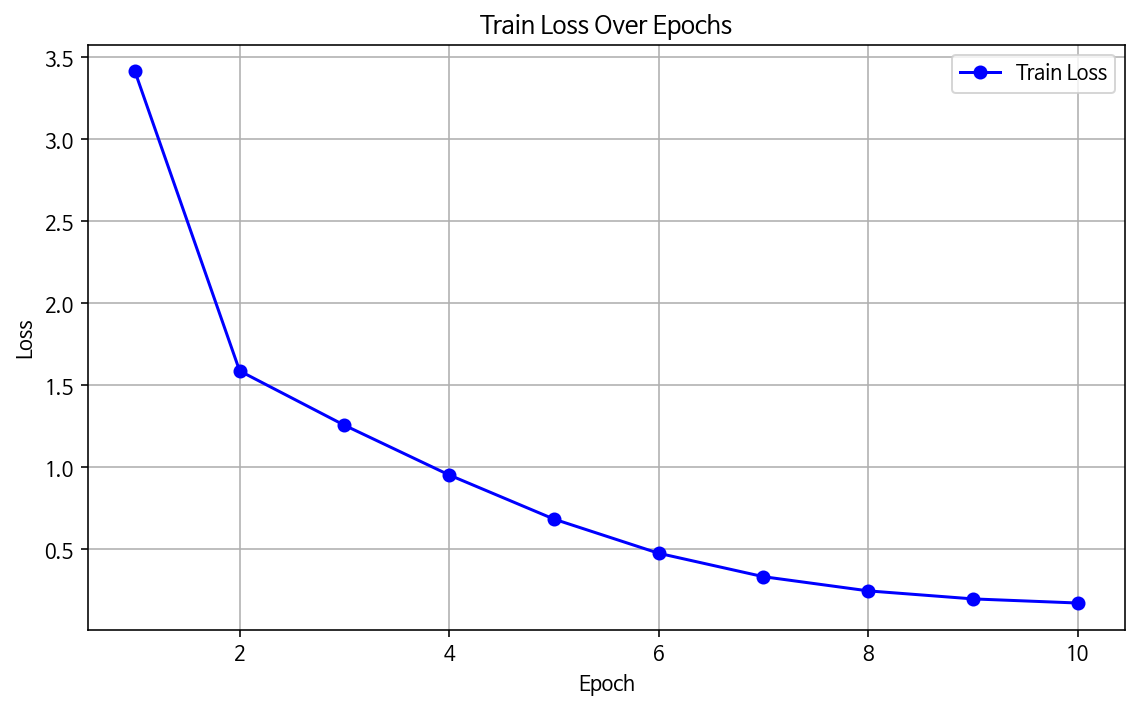

In [68]:
display_loss_graph(model_4_loss)

Translations and Attention Map
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: powerful richard since a month control laws work complex radio talks monday monday
Encoder Layer 1


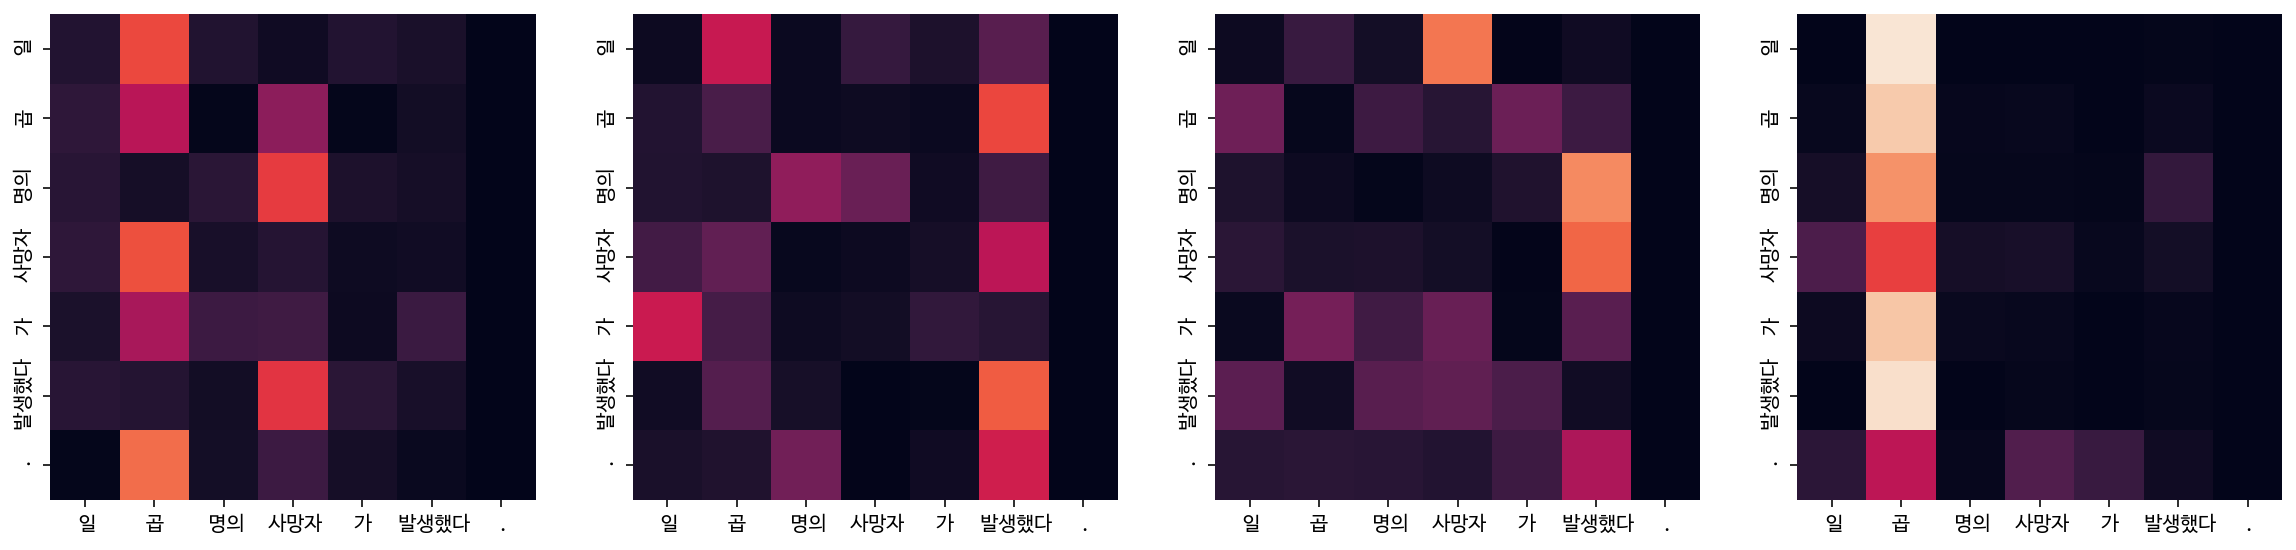

Encoder Layer 2


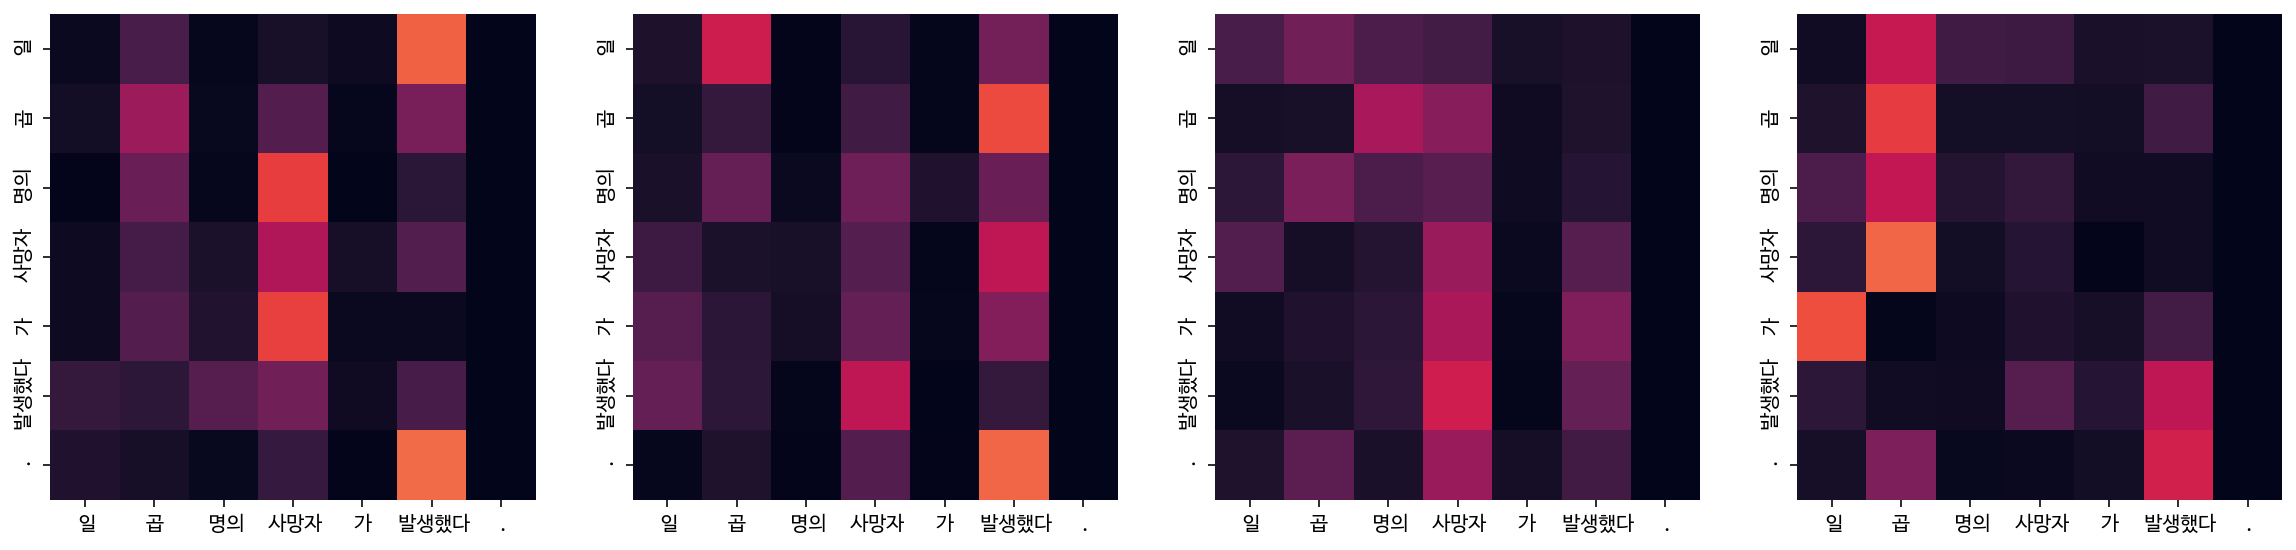

Decoder Self Layer 1


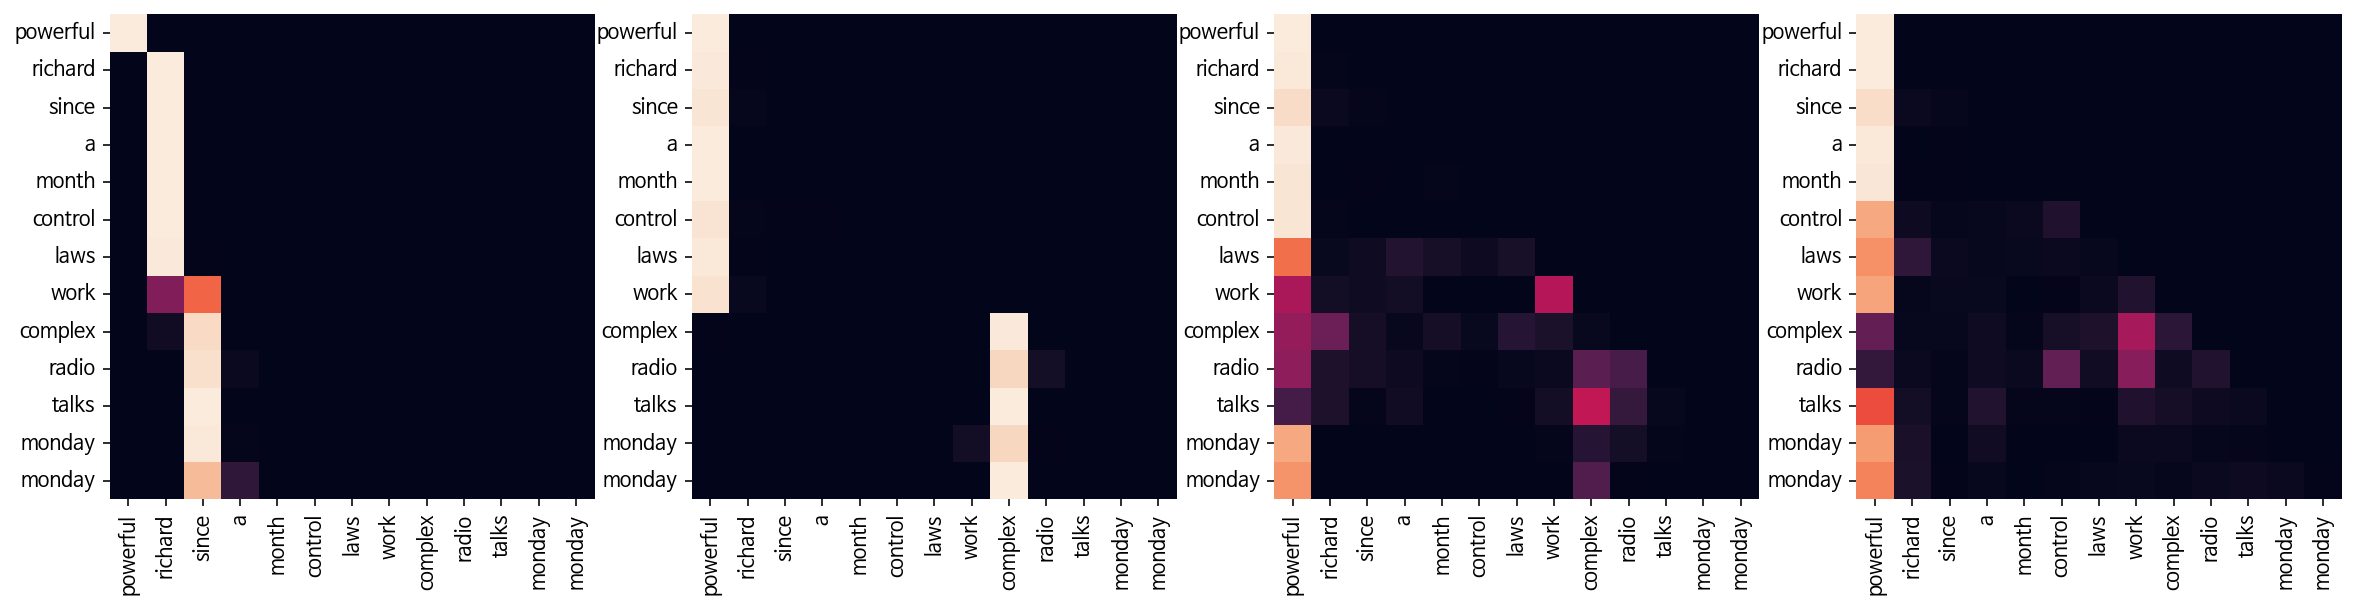

Decoder Src Layer 1


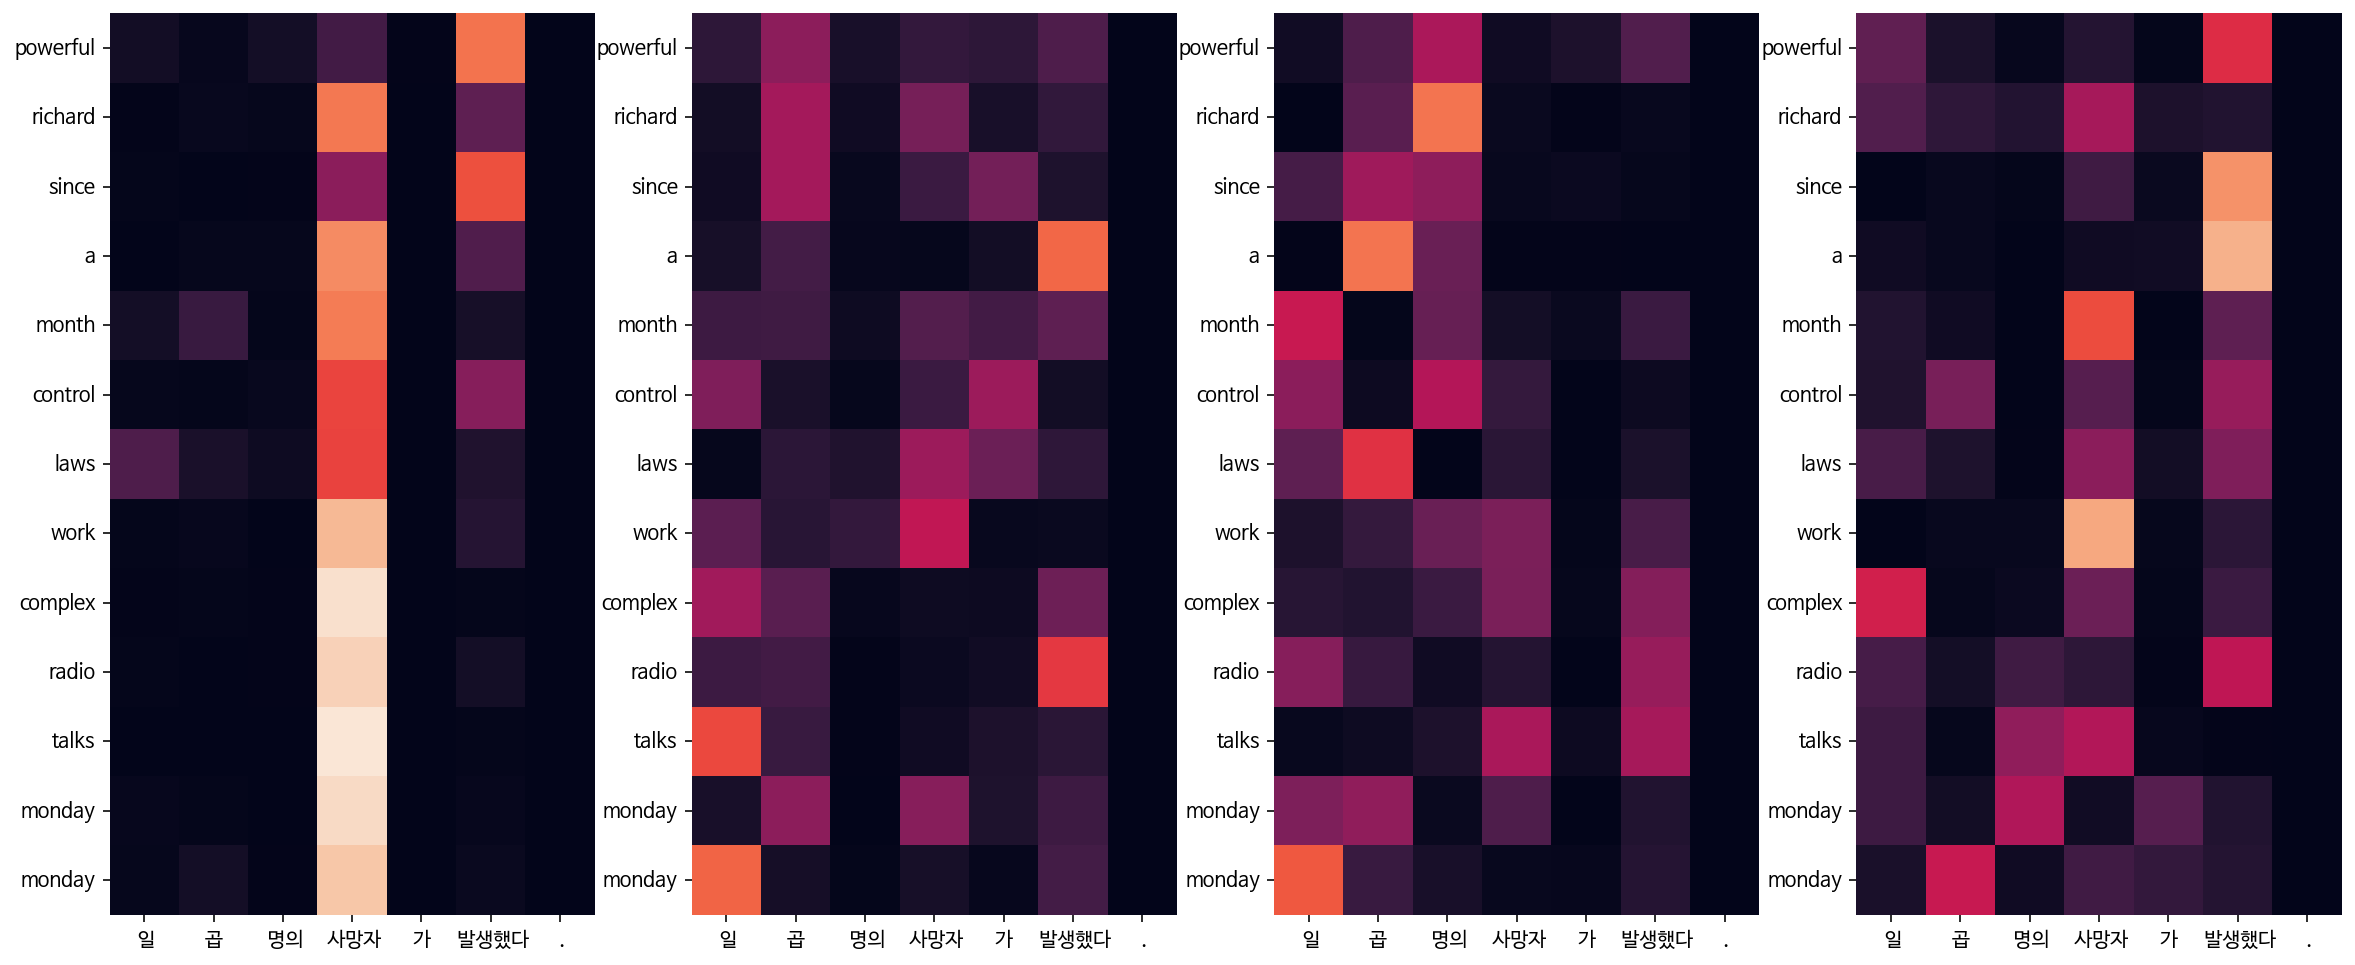

Decoder Self Layer 2


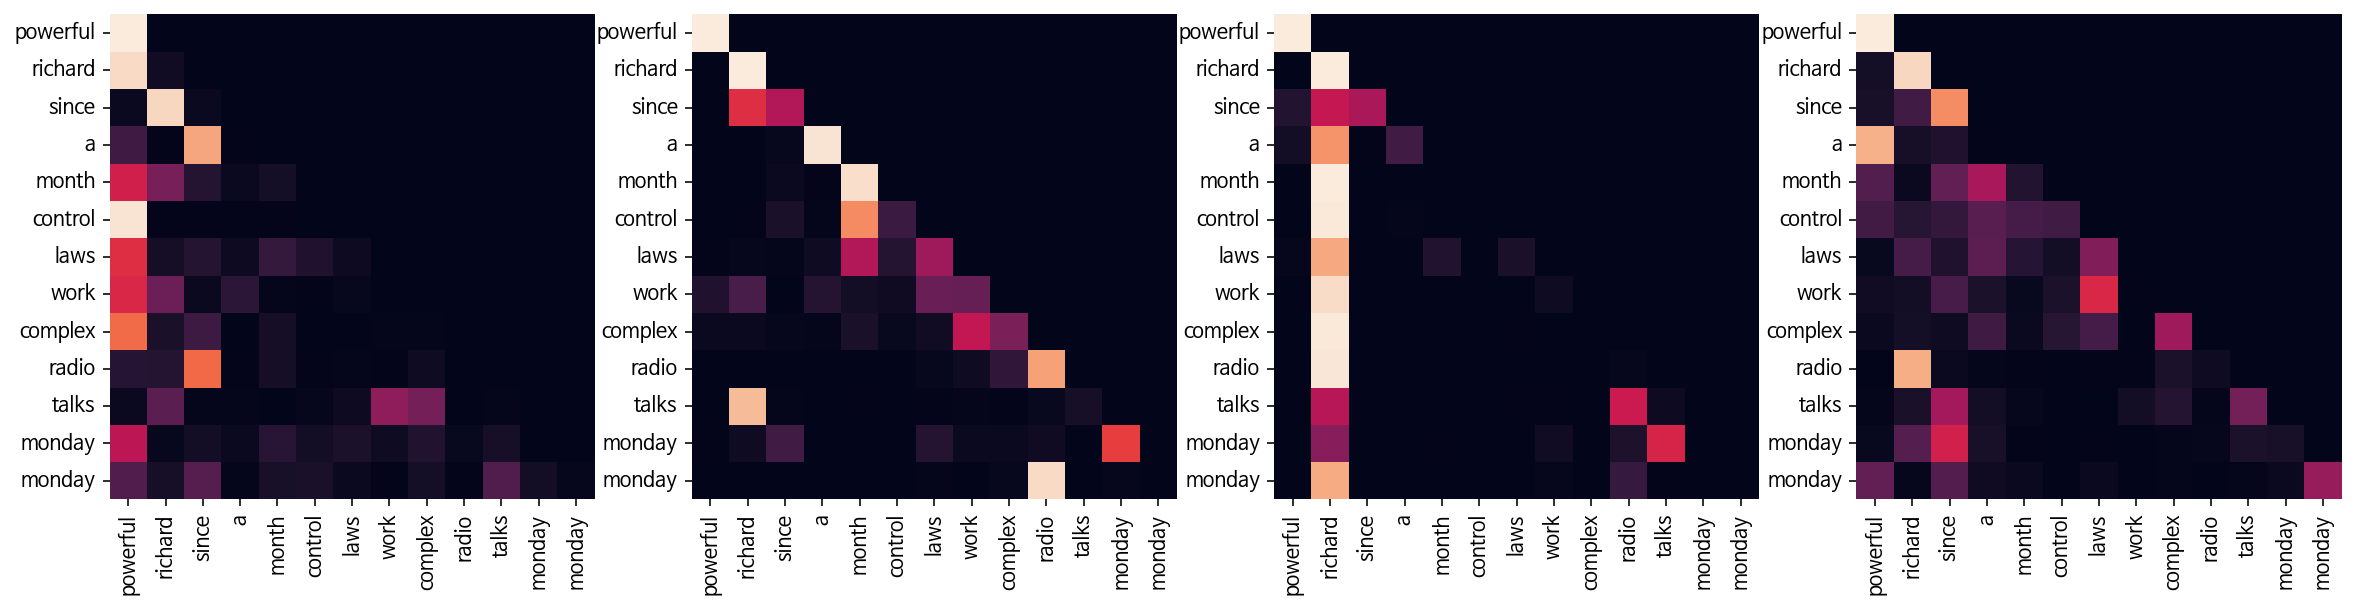

Decoder Src Layer 2


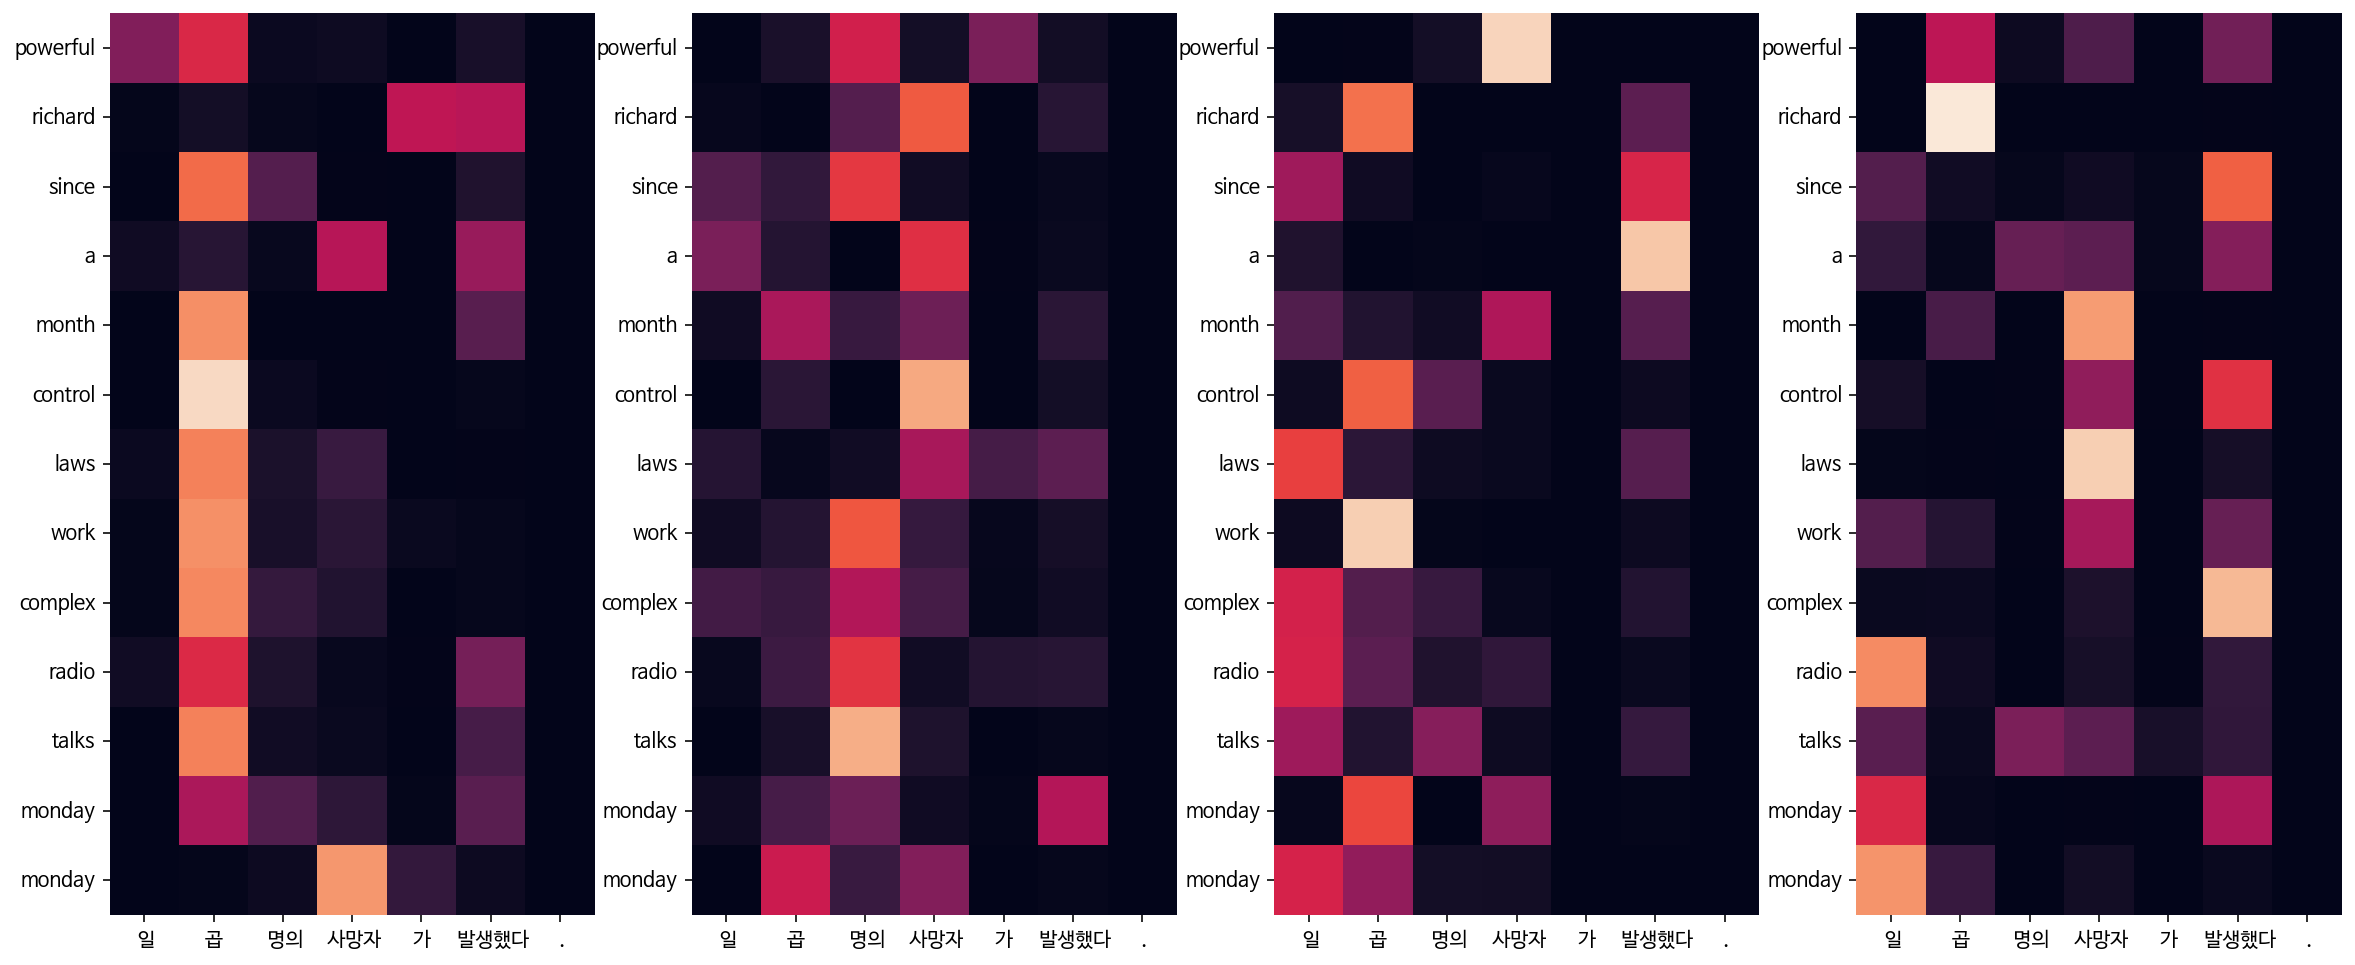

In [70]:
print("Translations and Attention Map")
sentence = [
    '일곱 명의 사망자가 발생했다.'
]
test_translate(transformer_2layer_aug, sentence, ko_aug_tokenizer, en_aug_tokenizer,)

In [69]:
# Bleu Score 
eval_bleu(transformer_2layer_aug, kor_test_corpus, eng_test_corpus, ko_aug_tokenizer, en_aug_tokenizer, MAX_LEN, False)

<class 'str'>


  0%|          | 0/1945 [00:00<?, ?it/s]

Num of Sample: 1945
Total Score: 0.0025733759493554264


# < 회고 >

## 루브릭 
1. 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

2. Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다

3. 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

4. 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
   - Augmenteation 없는 경우 : 77,082 set

5. 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.


### Data Augmenteation 
1. "Lexical Substitution" 방법으로 증강을 시도하였는데, 
    LMS(cloud container)에서 반응이 없는 것으로 보아 제대로 동작하지 않는 듯 함 (connection fail 발생)
    --> colab에서 증강 후, LMS로 다운로드하여 사용하려고 하였으나,
    --> colab에서 gensim, numpy, tensorflow의 version 문제가 있음
    
2. 데이타 증강 성공하여 테스트 case 4로 시험을 하였는데, 시간상 전체 27만 데이타를 사용하지 않고, 8만 데이타만 사용하여서 시험하였다.
   - Layer2일때의 시험과 비교
       + train loss가 천천히 줄어들었다 
       + test_sentence에 대해서 비슷한 결과를 출력하였다 
       + bleu score는 더 낮았다

### 실험 결과 기록 (Test Case Summary) 
1. N_Layer=2 와  N_Layer=6 비교 

   -  epoch당 시간 : 4.28분 , 9.22분
   -  Bleu Score 시간 : 11.53분, 
   -  epoch 10에서는 esimate 결과물이 좋지 않다.
      --> loss curve를 보면, 3~4 epoch일때까지 돌리는것이 좋을 것 같아
   
2. N_Layer=2 와 N_Layer=4 + d_model=256 비교
    - epoch당 시간 : 4.28분, 05.07분 
    
    
3. case별 정리

| Test Case ID | Description           | BLEU Score | n_layers | d_model | n_heads | d_ff | Dropout | Batch | Epoch | Notes                      |
|--------------|------------------------|------------|----------|---------|---------|------|---------|--------|--------|----------------------------|
| TC-01        | Baseline (No Augment)  | 0.003767   | 2        | 512     | 8       | 2048 | 0.3     | 64     | 10     |   epoch당 4.28분                         |
| TC-02        | Baseline + 층수 증가   | 0.001688   | 6        | 512     | 8       | 2048 | 0.3     | 64     | 10     | epoch당 9.22분   |
| TC-03       | Baseline + HP 조정   |  0.003501  | 4        | 256    | 8       | 2048 | 0.3     | 64     | 10     |    |
| TC-04        | Baseline + Augment   | 0.002573   | 2        | 512     | 8       | 2048 | 0.3     | 64     | 10     |   epoch당 4.20분                         |

### 정성 평가
- 층수가 6인경우 원문에 있는 단어와 연관된 영어단어들이 보다 많이 출력된다 

    + 오바마 : mccain, vote, democratic party, clinton
    + 사망자 : died, police, hospital
    + 일곱   : june, five
    + 도시   : tehran, syria, pennsylvania  


###  회고
 1. 팀 실험 결과 참고 : epoch 3으로 시험한 결과, layer 2사용시 bleu-score는 0.0092로 epoch 10일때보다 bleu-score가 좋게 나왔다
 
 2. 번역 결과가 제대로 나오지 않으므로 1, 2, 3,4 gram에 균등한 weight를 사용한 blue-score가 좋게 나올 수 없었을 것으로 생각된다. 
 
 3. sentencepice의 model_type을 bpe로 하는 것이 "일" "곱"으로 나뉘는 부분이 "일곱"으로 표현되니, unigram보다는 bpe가 더 좋을 것 같다